In [1]:
import sys
import pandas as pd
from load_data import get_data, load_pkl, save_pkl
from processing_helpers import get_cue_segments, get_power_spec, get_peak_fits, get_control_segments
import pickle as pkl
import numpy as np
import os
import matplotlib.pyplot as plt
from fooof import FOOOF
from scipy.stats import sem, f_oneway, ttest_ind
import pingouin as pg
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
from statsmodels.formula.api import ols
import analysis_helpers as ah

%matplotlib inline


In [2]:
# Global variables to store the session data
lfp_df = pd.DataFrame()
ch_num_list = []
lfp_mne = []
session_start_time = 0
markers = []
timeStamps = []
sampling_frequency = 0
cue_segments_df = pd.DataFrame()
control_segments_df = pd.DataFrame()

theta_range = [3, 12]

In [3]:
def load_data(day):
    """
    Load LFP data for a given day.
    """
    global lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency
    print(f"Loading data for {day}...")
    lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency = get_data(day)

    if lfp_df is not None:
        print(f"Loaded {len(ch_num_list)} channels.")
        print(lfp_df.head())
    else:
        print("Failed to load data.")

def compute_theta_trials(data, key='flat_spec_og'):
    """
    For each trial in the DataFrame, compute the sum of power in the theta band.
    """
    if data.empty:
        return []
    psd_list = data[key].tolist()
    lengths = [arr.shape[0] for arr in psd_list if hasattr(arr, 'shape')]
    if not lengths:
        return []
    min_length = min(lengths)
    # Compute the theta power by summing values in indices corresponding to theta_range
    trial_values = [np.sum(psd[:min_length][theta_range[0]:theta_range[1]]) for psd in psd_list]
    return trial_values


In [37]:
# Load Raw Data
day = "20181105"
load_data(day)

# Extract segments with a specific window size and process
window_size = 1000  # e.g., 1000 ms
peak_fit_range = [1,14]

interesting_ch = {
    '20181102' : [9,19,26,29,30,31,43,45],
    '20181105' : [19,23,29,30,43,45],
    '20181101' : [19,21,23,29,30,35,43,45],
    '20181031' : [19,26,29,30,35,43,45],
    '20181026' : [19,29,30,35,45],
    '20181022' : [9,17,26,29,43,45]
}

cue_segments_df = load_pkl(f"/Users/liuyuanwei/Desktop/Data Processed/{day}/{day}_cue.pkl")
control_segments_df = load_pkl(f"/Users/liuyuanwei/Desktop/Data Processed/{day}/{day}_control.pkl")


channel_no = sorted(cue_segments_df['channel'].unique())
ch_indx = []
for i in interesting_ch[day]:
    ch_str = f"{i:03}"
    if ch_str in channel_no:
        ch_indx.append(channel_no.index(ch_str))

# --- Preprocess: Convert channel values to zero-padded strings ---
cue_segments_df['channel'] = cue_segments_df['channel'].apply(lambda x: f"{int(x):03}")


cue_segments_df['theta_power'] = cue_segments_df['flat_spec_og'].apply(lambda x: np.sum(x[theta_range[0]:theta_range[1]]))
# Define pillar groupings and mapping for colors
pillar_destination = [[11, 16], [12], [13], [14, 15]]
pillar_start = [[31, 36], [32], [33], [34, 35]]

pillar_color_map = {
    0: 'blue',    # Pillar 1: Posters 1 & 6
    1: 'yellow',  # Pillar 2: Poster 2
    2: 'green',   # Pillar 3: Poster 3
    3: 'red'      # Pillar 4: Posters 4 & 5
}

def map_to_pillar(value, mapping):
    """
    Map a given numeric value to a pillar group index based on a provided mapping list.
    """
    for i, group in enumerate(mapping):
        if value in group:
            return i
    return np.nan

# Create new columns for pillar start and pillar destination.
cue_segments_df['pillar_start'] = cue_segments_df['start_position'].apply(lambda x: map_to_pillar(x, pillar_start))
cue_segments_df['pillar_destination'] = cue_segments_df['cue_onset'].apply(lambda x: map_to_pillar(x, pillar_destination))

Loading data for 20181022...
Creating RawArray with float64 data, n_channels=26, n_times=4942248
    Range : 0 ... 4942247 =      0.000 ...  4942.247 secs
Ready.
Loaded 26 channels.
  channel                                           lfp_data
0     009  [-27.75402, -34.08107, -40.772938, -47.257298,...
1     011  [-27.344744, -37.01008, -45.88219, -53.340084,...
2     015  [-6.871894, -15.076549, -20.76433, -22.831646,...
3     017  [-30.176159, -36.58838, -42.57443, -47.445915,...
4     020  [-12.394248, -18.977497, -24.733387, -29.35527...
Data successfully loaded from /Users/liuyuanwei/Desktop/Data Processed/20181022/20181022_cue.pkl
Loaded data has 10374 rows and 14 columns.
                                             segment channel start_position  \
0  [9.893615, 7.5915875, 3.9290628, 0.5271555, -1...     009             36   
1  [4.7024913, 2.796567, 1.1272492, 1.355152, 4.2...     011             36   
2  [19.14239, 17.051285, 15.416498, 15.21809, 16....     015             36

## Starting all Over

##### Begin with 2 Way ANOVA
##### Look at 1 Way ANOVA Start Locations
##### Look at 1 Way ANOVA Cue Onset

One-way ANOVA results for theta power by interesting channel:
                  sum_sq      df           F         PR(>F)
C(channel)   6442.244706     5.0  266.402719  9.274501e-227
Residual    11549.491986  2388.0         NaN            NaN

Significant effect detected! Running Tukey HSD post hoc analysis:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   019    023   3.8675    0.0  3.4234  4.3115   True
   019    029  -0.0168    1.0 -0.4609  0.4273  False
   019    030   0.0851 0.9942  -0.359  0.5291  False
   019    043  -1.0119    0.0  -1.456 -0.5678   True
   019    045   -0.912    0.0 -1.3561  -0.468   True
   023    029  -3.8843    0.0 -4.3283 -3.4402   True
   023    030  -3.7824    0.0 -4.2265 -3.3383   True
   023    043  -4.8794    0.0 -5.3234 -4.4353   True
   023    045  -4.7795    0.0 -5.2236 -4.3354   True
   029    030   0.1019 0.9867 -0.3422  0.5459  False
  

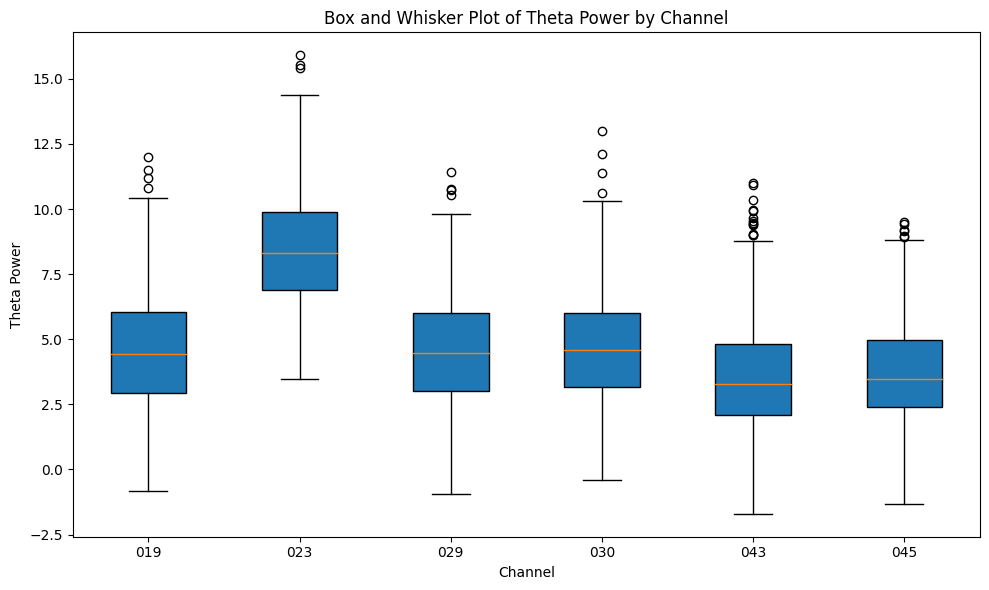

In [7]:
alpha = 0.05

# Format the interesting channels as three-digit strings (e.g., "001", "002")
interesting_channels = [f"{ch:03}" for ch in interesting_ch[day]]

# Filter the dataframe to include only the interesting channels
df_interesting = cue_segments_df[cue_segments_df['channel'].isin(interesting_channels)]

# Build the one-way ANOVA model using channel as a factor on the filtered data.
model_channel_interesting = ols('theta_power ~ C(channel)', data=df_interesting).fit()

# Run the ANOVA (using type II sums of squares).
anova_results_interesting = sm.stats.anova_lm(model_channel_interesting, typ=2)

# Print the ANOVA table for the interesting channels only.
print("One-way ANOVA results for theta power by interesting channel:")
print(anova_results_interesting)

if anova_results_interesting.loc['C(channel)', 'PR(>F)'] < alpha:
    print("\nSignificant effect detected! Running Tukey HSD post hoc analysis:")
    
    # Run Tukey's HSD post hoc test:
    tukey_results = pairwise_tukeyhsd(endog=df_interesting['theta_power'],
                                      groups=df_interesting['channel'],
                                      alpha=alpha)
    print(tukey_results)
else:
    print("\nNo significant effect detected; post hoc analysis is not performed.")

plt.figure(figsize=(10, 6))

channels = sorted(df_interesting['channel'].unique())
data_box = [df_interesting.loc[df_interesting['channel'] == ch, 'theta_power'] for ch in channels]

plt.boxplot(data_box, labels=channels, patch_artist=True)
plt.xlabel("Channel")
plt.ylabel("Theta Power")
plt.title("Box and Whisker Plot of Theta Power by Channel")
plt.tight_layout()
plt.show()


In [44]:
result_df2.keys()

Index(['Channel', 'pillar_start', 'cue_onset', 'pillar_start:cue_onset'], dtype='object')

In [47]:
import os
import pandas as pd
import numpy as np

# ————————————————————————————————————————————————————————————————
def compute_venn_counts(result_df, factors, alpha=0.05):
    """
    Returns a dict of counts in each of the 8 Venn regions:
      only factor1, only factor2, only interaction,
      f1∩f2 only, f1∩int only, f2∩int only,
      all three, and none.
    Assumes result_df has columns:
       factors[0], factors[1], f"{factors[0]}:{factors[1]}", and 'Channel'
    """
    f1, f2 = factors
    p1    = f1
    p2    = f2
    pint  = f"{f1}:{f2}"

    sig1 = set(result_df.loc[result_df[p1]   < alpha, 'Channel'])
    sig2 = set(result_df.loc[result_df[p2]   < alpha, 'Channel'])
    sig3 = set(result_df.loc[result_df[pint] < alpha, 'Channel'])

    all_ch   = set(result_df['Channel'])
    union123 = sig1 | sig2 | sig3

    return {
        f"{f1}_only":       len(sig1   - sig2     - sig3),
        f"{f2}_only":       len(sig2   - sig1     - sig3),
        "interaction_only": len(sig3   - sig1     - sig2),
        f"{f1}_{f2}_only":  len((sig1 & sig2)     - sig3),
        f"{f1}_int_only":   len((sig1 & sig3)     - sig2),
        f"{f2}_int_only":   len((sig2 & sig3)     - sig1),
        "all_three":        len(sig1 & sig2 & sig3),
        "none":             len(all_ch - union123),
    }

# ————————————————————————————————————————————————————————————————
output_base = f"/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/{day}"

# build first_peak column once
cue_segments_df['first_peak'] = cue_segments_df['peak_freqs'].apply(
    lambda peaks: peaks[0] if isinstance(peaks, (list, np.ndarray)) and len(peaks)>0 else np.nan
)

jobs = [
    ("theta_power", "Theta_Power",
        [("start_position","cue_onset","StartPoster_CuePoster_results"),
         ("pillar_start",  "cue_onset","StartPillar_CuePoster_results"),
         ("start_position","pillar_destination","StartPoster_CuePillar_results"),
         ("pillar_start",  "pillar_destination","StartPillar_CuePillar_results"),
        ]),
    ("first_peak",  "Theta_Peak",
        [("start_position","cue_onset","StartPoster_CuePoster_results"),
         ("pillar_start",  "cue_onset","StartPillar_CuePoster_results"),
         ("start_position","pillar_destination","StartPoster_CuePillar_results"),
         ("pillar_start",  "pillar_destination","StartPillar_CuePillar_results"),
        ]),
]

channels = [int(x) for x in sorted(cue_segments_df['channel'].unique())]

for dependent, main_folder, analyses in jobs:
    for f1, f2, subdir in analyses:
        out_dir = os.path.join(output_base, main_folder, subdir)

        # 1) run the pipeline
        result_df = ah.run_analysis_pipeline(
            cue_segments_df, channels,
            dependent=dependent,
            factors=[f1, f2],
            plot_groups=(f1, f2),
            output_folder=out_dir,
            alpha=0.05
        )

        # 2) compute the counts
        counts = compute_venn_counts(result_df, (f1, f2), alpha=0.05)

        # 3) dump to CSV
        os.makedirs(out_dir, exist_ok=True)
        row = {
            "dependent": dependent,
            "factor1":   f1,
            "factor2":   f2,
            **counts
        }
        df_counts = pd.DataFrame([row])
        csv_path = os.path.join(out_dir, "venn_counts.csv")
        df_counts.to_csv(csv_path, index=False)

        print(f"Written counts for {dependent} [{f1} vs {f2}] to {csv_path}")


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The numb


=== theta_power :: start_position vs cue_onset ===
  start_position only:         0
  cue_onset only:         6
  Interaction only:  6
  start_position ∩ cue_onset only:  0
  start_position ∩ Int only:    1
  cue_onset ∩ Int only:    0
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The numb


=== theta_power :: pillar_start vs cue_onset ===
  pillar_start only:         3
  cue_onset only:         3
  Interaction only:  0
  pillar_start ∩ cue_onset only:  0
  pillar_start ∩ Int only:    1
  cue_onset ∩ Int only:    0
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The numb


=== theta_power :: start_position vs pillar_destination ===
  start_position only:         1
  pillar_destination only:         5
  Interaction only:  2
  start_position ∩ pillar_destination only:  0
  start_position ∩ Int only:    1
  pillar_destination ∩ Int only:    0
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number


=== theta_power :: pillar_start vs pillar_destination ===
  pillar_start only:         1
  pillar_destination only:         7
  Interaction only:  2
  pillar_start ∩ pillar_destination only:  0
  pillar_start ∩ Int only:    0
  pillar_destination ∩ Int only:    0
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The numb


=== first_peak :: start_position vs cue_onset ===
  start_position only:         2
  cue_onset only:         2
  Interaction only:  3
  start_position ∩ cue_onset only:  0
  start_position ∩ Int only:    1
  cue_onset ∩ Int only:    1
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The numb


=== first_peak :: pillar_start vs cue_onset ===
  pillar_start only:         5
  cue_onset only:         0
  Interaction only:  1
  pillar_start ∩ cue_onset only:  0
  pillar_start ∩ Int only:    0
  cue_onset ∩ Int only:    0
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The numb


=== first_peak :: start_position vs pillar_destination ===
  start_position only:         3
  pillar_destination only:         0
  Interaction only:  2
  start_position ∩ pillar_destination only:  0
  start_position ∩ Int only:    0
  pillar_destination ∩ Int only:    0
  All three:         0


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number


=== first_peak :: pillar_start vs pillar_destination ===
  pillar_start only:         3
  pillar_destination only:         0
  Interaction only:  2
  pillar_start ∩ pillar_destination only:  0
  pillar_start ∩ Int only:    0
  pillar_destination ∩ Int only:    0
  All three:         0


In [ ]:
# wherever you build cue_segments_df, do:
cue_segments_df['first_peak'] = cue_segments_df['peak_freqs'].apply(
    lambda peaks: peaks[0] if isinstance(peaks, (list, np.ndarray)) and len(peaks) > 0 else np.nan
)

# then just change dependent="peak_freqs" → dependent="first_peak_freq"
output_folder = f"/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/{day}/Theta_Peak/"

result_df = ah.run_analysis_pipeline(
    cue_segments_df, channels,
    dependent="first_peak",
    factors=["start_position", "cue_onset"],
    plot_groups=("start_position", "cue_onset"),
    output_folder=os.path.join(output_folder, 'StartPoster_CuePoster_results'),
    alpha=0.05
)

result_df = ah.run_analysis_pipeline(
    cue_segments_df, channels,
    dependent="first_peak",
    factors=["pillar_start", "cue_onset"],
    plot_groups=("pillar_start", "cue_onset"),
    output_folder=os.path.join(output_folder, 'StartPillar_CuePoster_results'),
    alpha=0.05
)

result_df = ah.run_analysis_pipeline(
    cue_segments_df, channels,
    dependent="first_peak",
    factors=["start_position", "pillar_destination"],
    plot_groups=("start_position", "pillar_destination"),
    output_folder=os.path.join(output_folder, 'StartPoster_CuePillar_results'),
    alpha=0.05
)

result_df = ah.run_analysis_pipeline(
    cue_segments_df, channels,
    dependent="first_peak",
    factors=["pillar_start", "pillar_destination"],
    plot_groups=("pillar_start", "pillar_destination"),
    output_folder=os.path.join(output_folder, 'StartPillar_CuePillar_results'),
    alpha=0.05
)

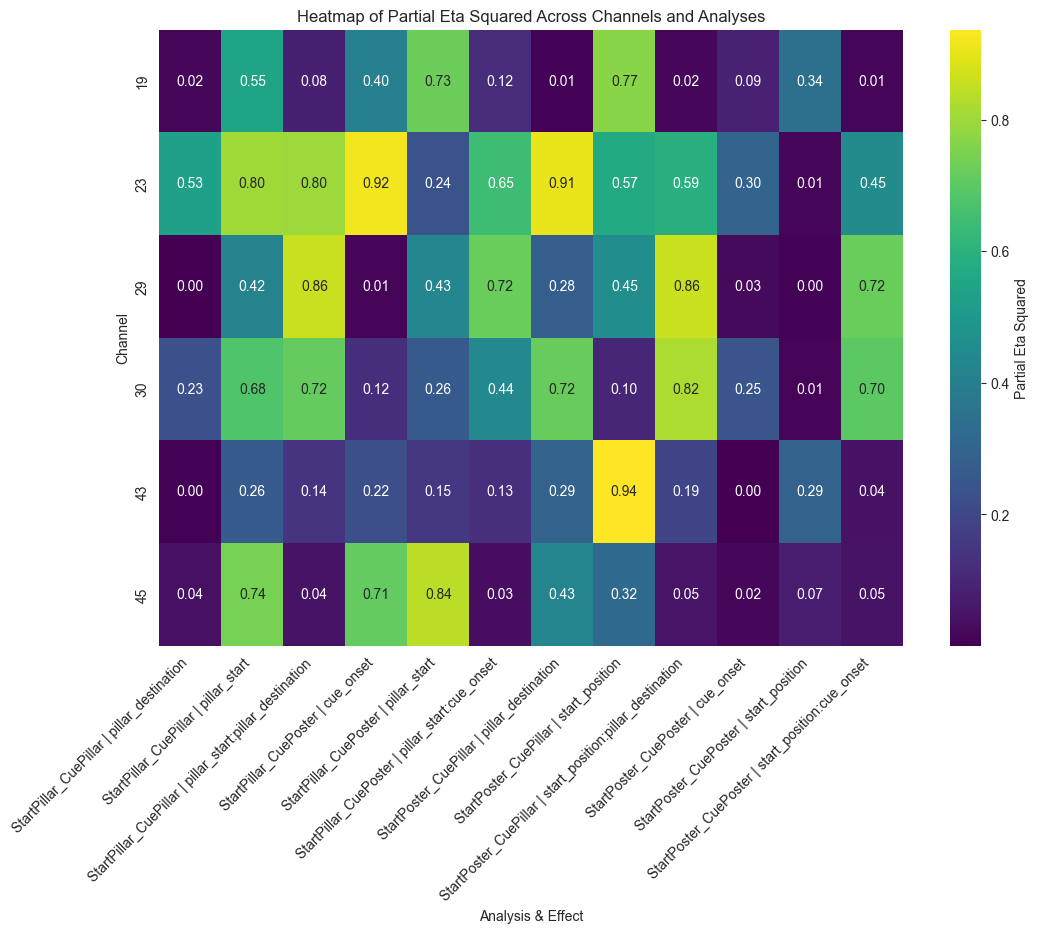

In [20]:
# Tag each DataFrame with an analysis label.
result_df1['Analysis'] = 'StartPoster_CuePoster'
result_df2['Analysis'] = 'StartPillar_CuePoster'
result_df3['Analysis'] = 'StartPoster_CuePillar'
result_df4['Analysis'] = 'StartPillar_CuePillar'

# (Optional) If your result DataFrames also include p-values in columns with the same names,
# you might want to extract only the partial eta squared values.
# For example, if the keys for partial eta squared values are from your eta_sq_dict, then
# pick those columns plus "Channel" and "Analysis".
# Let’s say the eta keys are known (they will be your factors and their interaction).
# For the 'StartPoster_CuePoster' analysis with factors ["start_position", "cue_onset"],
# the columns should be: "Channel", "start_position", "cue_onset", "start_position:cue_onset", and "Analysis".
# Adjust the following selection to your case:
eta_cols1 = ['Channel', 'start_position', 'cue_onset', 'start_position:cue_onset', 'Analysis']
eta_cols2 = ['Channel', 'pillar_start', 'cue_onset', 'pillar_start:cue_onset', 'Analysis']
eta_cols3 = ['Channel', 'start_position', 'pillar_destination', 'start_position:pillar_destination', 'Analysis']
eta_cols4 = ['Channel', 'pillar_start', 'pillar_destination', 'pillar_start:pillar_destination', 'Analysis']

result_df1 = result_df1[eta_cols1]
result_df2 = result_df2[eta_cols2]
result_df3 = result_df3[eta_cols3]
result_df4 = result_df4[eta_cols4]

# Concatenate all result DataFrames into one.
combined_df = pd.concat([result_df1, result_df2, result_df3, result_df4], ignore_index=True)

# Reshape the DataFrame:
# Melt the DataFrame so that each row corresponds to a single (Channel, Analysis, Effect) measurement.
melted_df = combined_df.melt(id_vars=["Channel", "Analysis"],
                               var_name="Effect", value_name="Partial_Eta_Squared")

# (Optional) If any of the effects are not partial eta squared (for example, if there are any p-value columns left)
# you can filter them out. For example, if your p-value columns have names starting with "p_",
# do a filter like:  melted_df = melted_df[~melted_df["Effect"].str.startswith("p_")]


heatmap_df = melted_df.pivot_table(
    index="Channel",
    columns=["Analysis", "Effect"],
    values="Partial_Eta_Squared"
)

# Sort channel indices if desired
heatmap_df = heatmap_df.sort_index()

# Flatten the MultiIndex into a single level by joining Analysis and Effect with an underscore
heatmap_df.columns = [
    f'{analysis} | {effect}'
    for analysis, effect in heatmap_df.columns
]

# Convert the pivot table to a NumPy array for plotting.
heatmap_data = heatmap_df.values
plt.figure(figsize=(12, 8))

# Use a nice style
sns.set_style("whitegrid")

# Plot the heatmap
ax = sns.heatmap(
    heatmap_df,
    cmap="viridis",          # You can try "YlGnBu", "magma", etc.
    annot=True,              # Annotate cells with values
    fmt=".2f",               # Format the numbers to 2 decimals
    cbar_kws={"label": "Partial Eta Squared"}
)

# Customize axes labels and title
ax.set_title("Heatmap of Partial Eta Squared Across Channels and Analyses")
ax.set_xlabel("Analysis & Effect")
ax.set_ylabel("Channel")

# Rotates tick labels on X-axis if they are long
plt.xticks(rotation=45, ha="right")

# Save and show
plt.savefig(
    os.path.join(
        "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Theta_Power",
        "Partial_Eta_Squared_Heatmap_Improved.png"
    ),
    dpi=300,
    bbox_inches="tight"
)
plt.show()


## Plotting Average Theta power

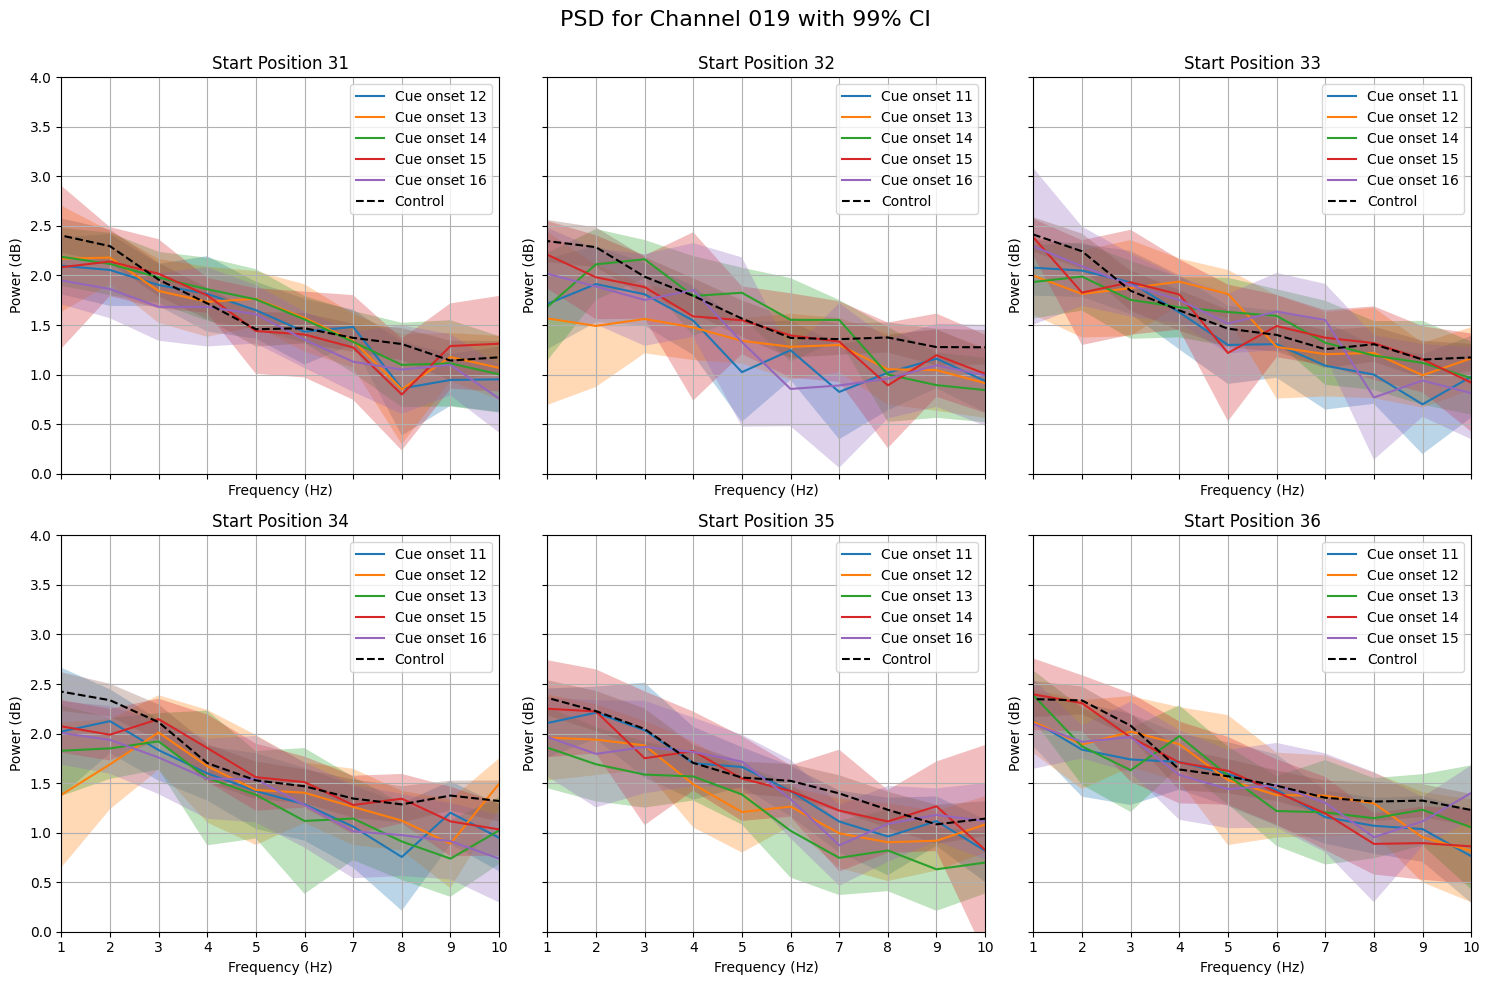

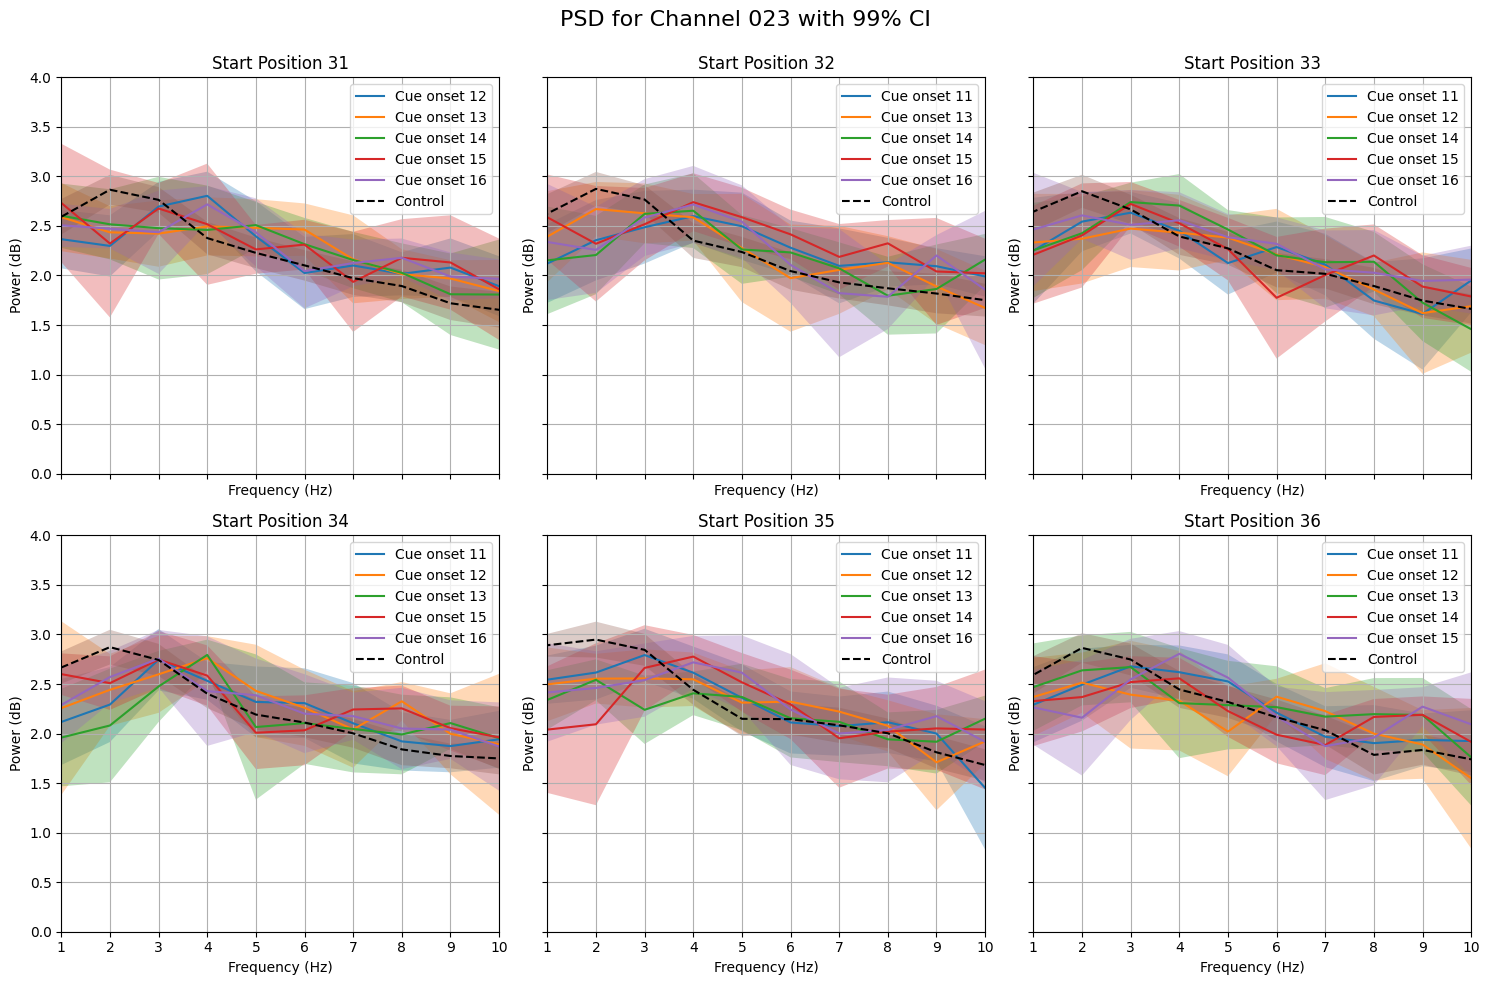

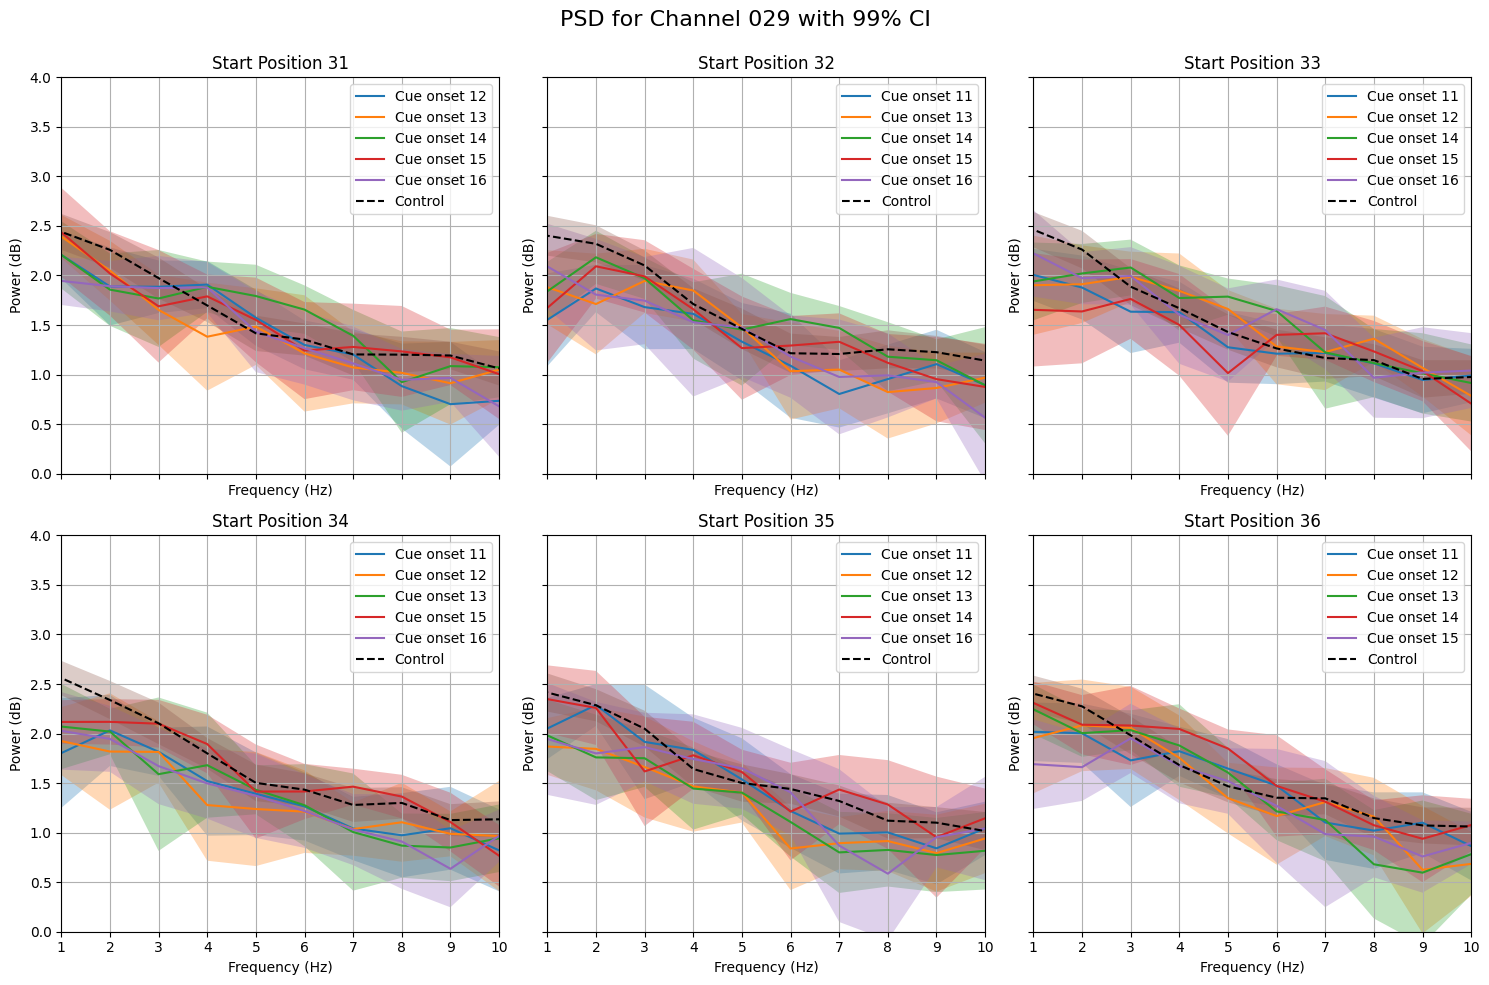

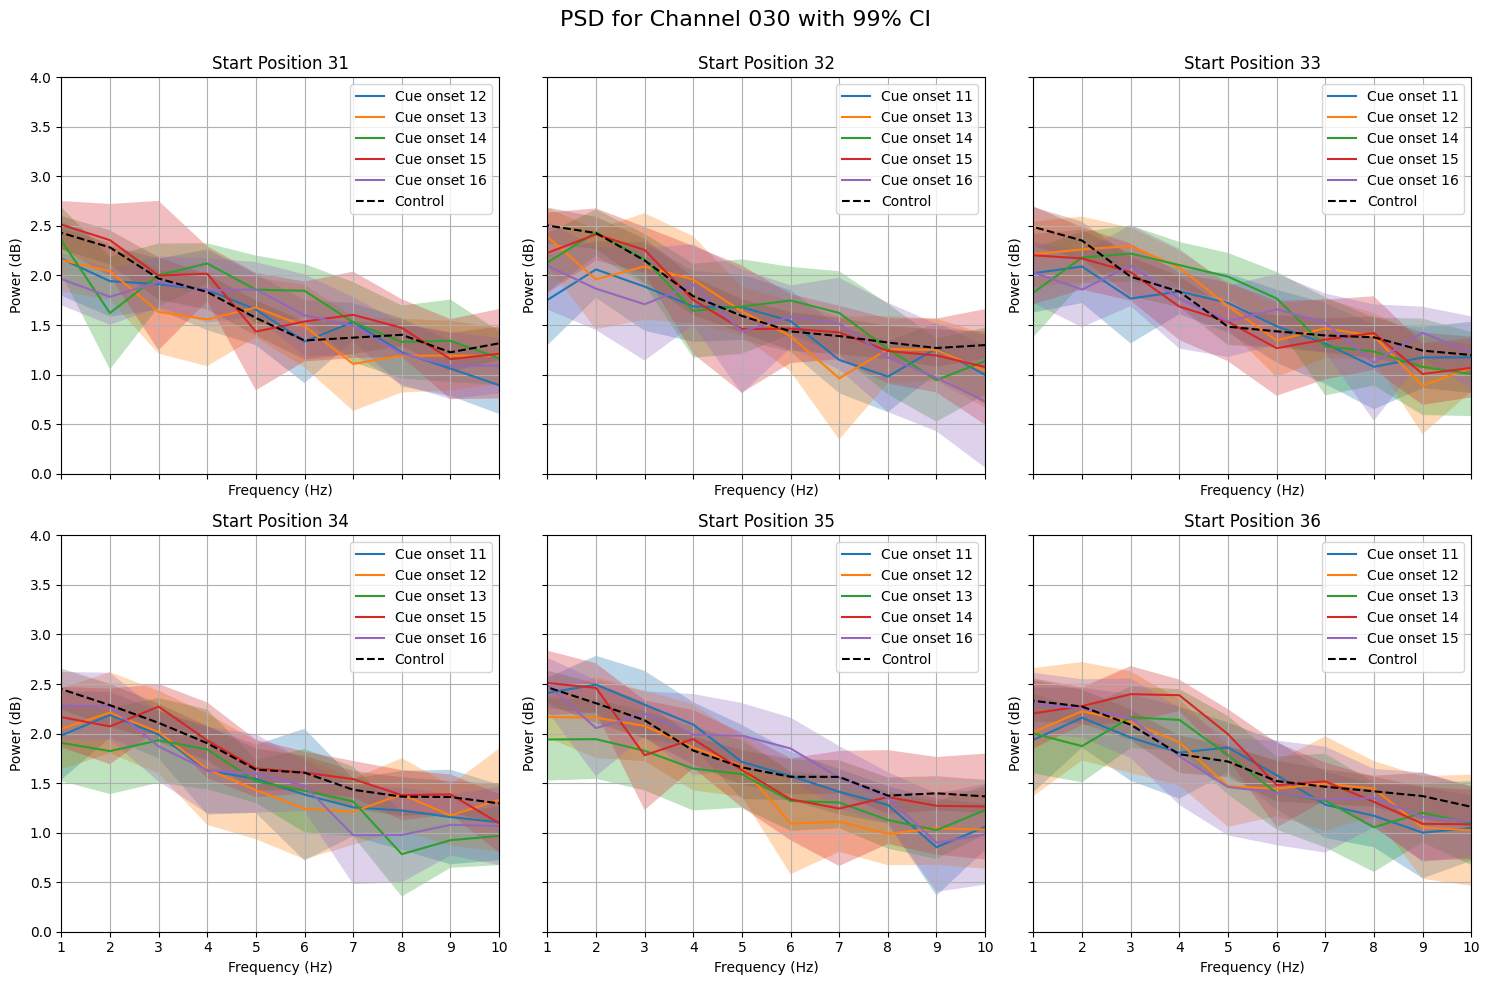

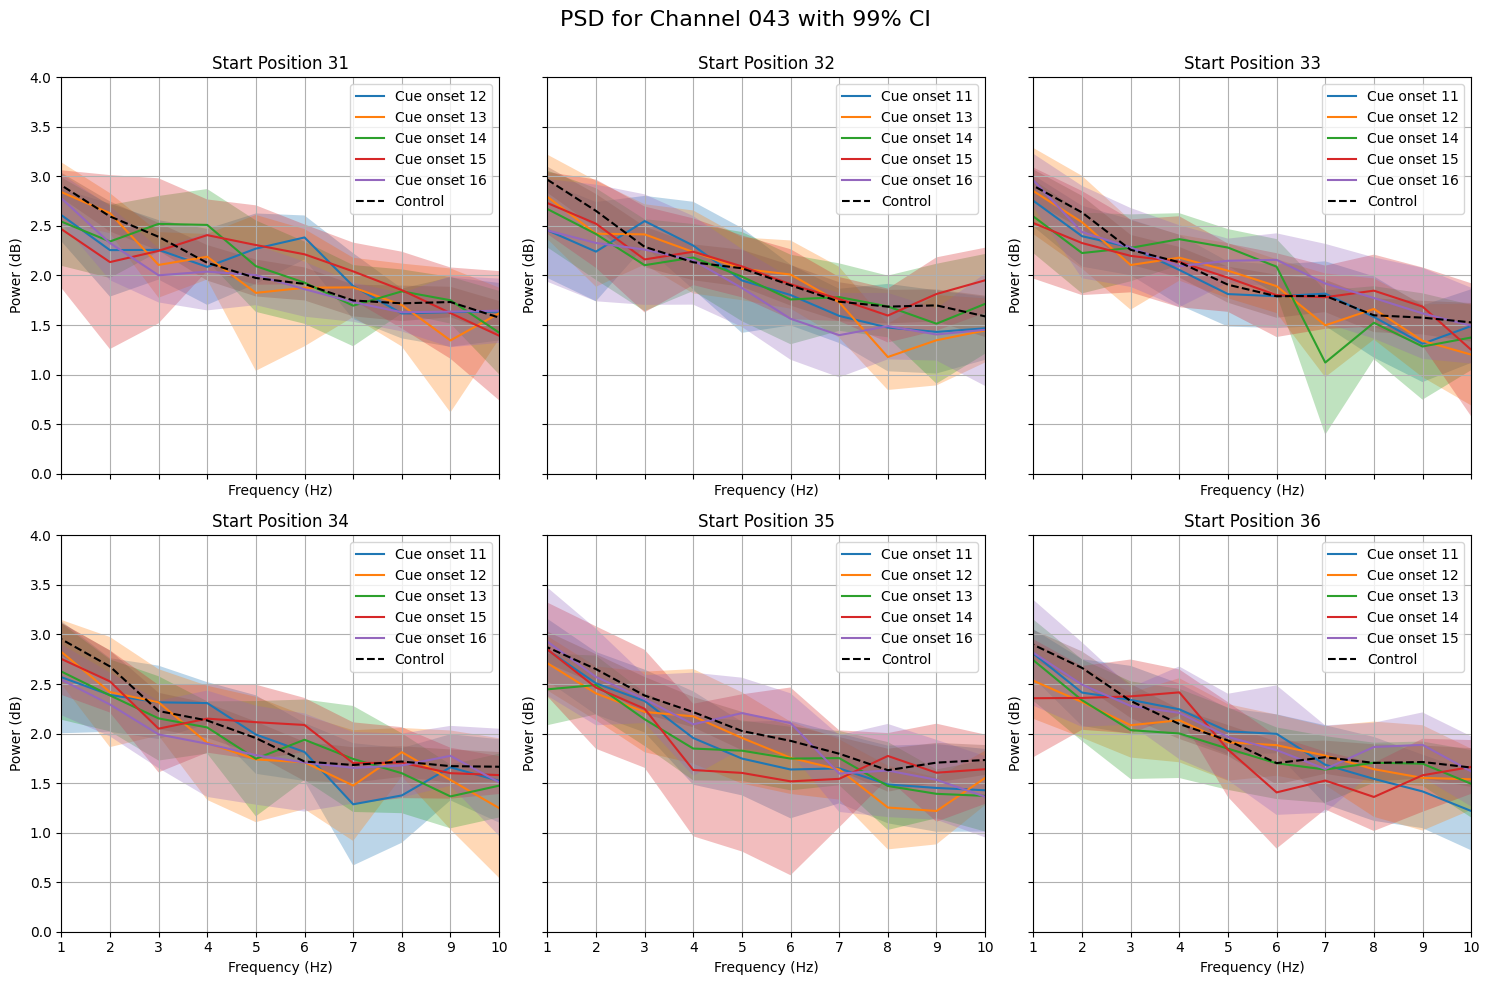

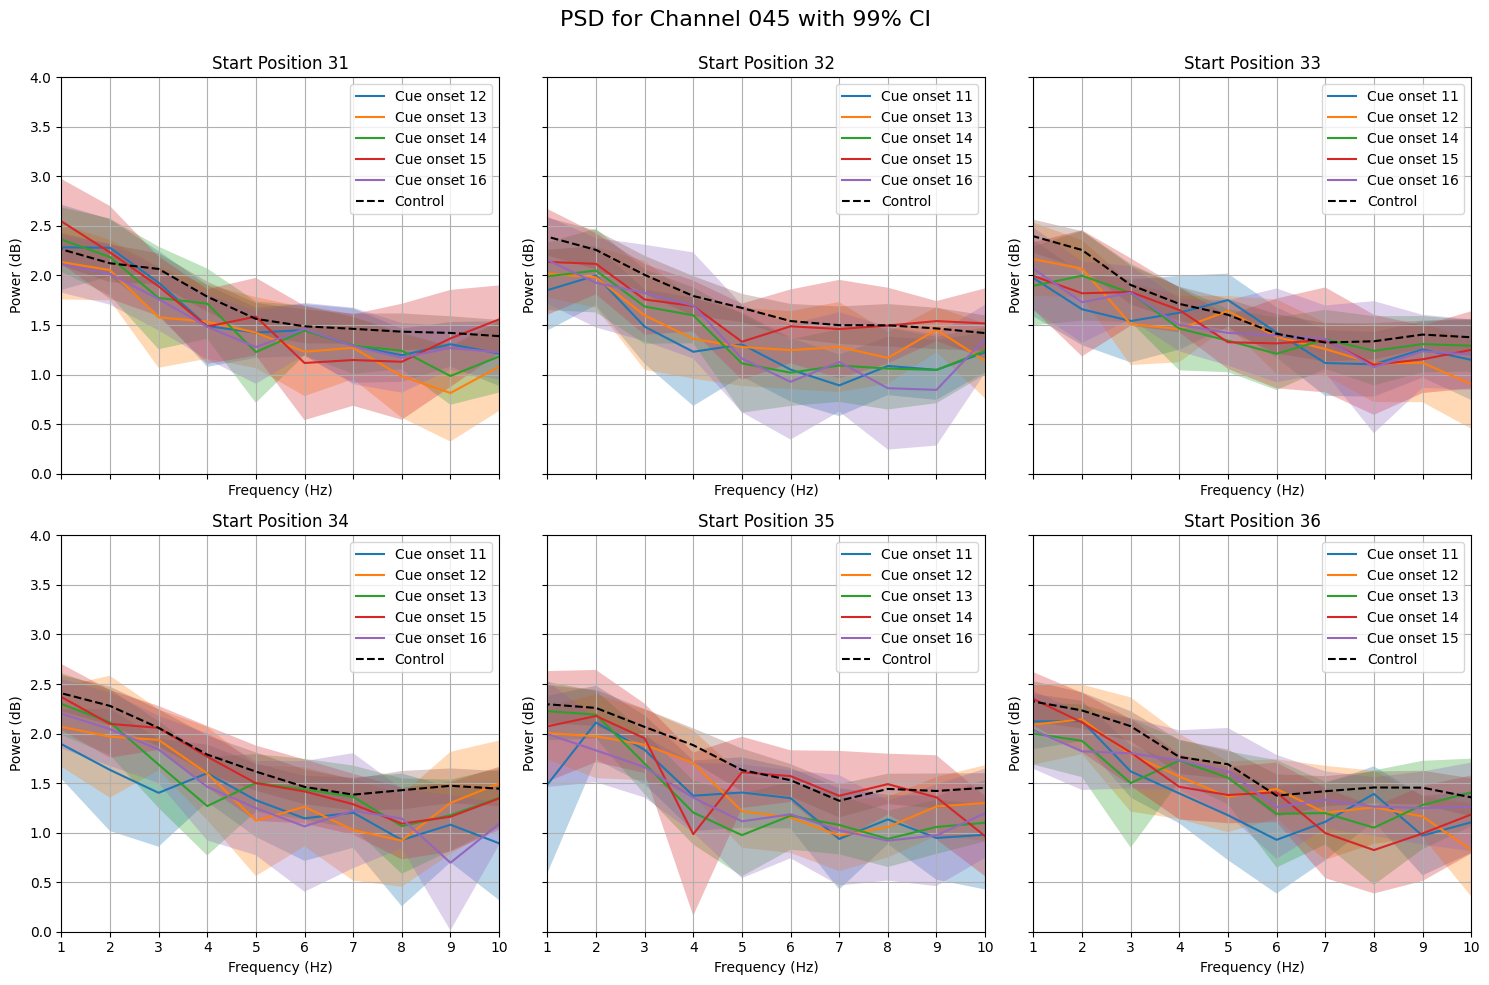

In [31]:
# Create a sorted list of unique channel numbers from your cue data
channel_no = sorted(cue_segments_df['channel'].unique())

# Get indices of channels from channel_no that match the interesting channels for the given day
ch_indx = []
for i in interesting_ch[day]:
    ch_str = f"{i:03}"
    if ch_str in channel_no:
        ch_indx.append(channel_no.index(ch_str))

# --- Helper function to compute mean, SEM, and frequency vector from PSD arrays ---
def process_psd_arrays(data, key='psd'):
    psd_list = data[key].values
    if len(psd_list) == 0:
        return None, None, None
    # Determine the minimum length among arrays to allow stacking
    lengths = [arr.shape[0] for arr in psd_list if hasattr(arr, 'shape')]
    if not lengths:
        return None, None, None
    min_length = min(lengths)
    # Trim each array to the minimum length and stack them
    psd_stack = np.stack([arr[:min_length] for arr in psd_list])
    mean_val = psd_stack.mean(axis=0)
    sem_val = sem(psd_stack, axis=0)
    # Get the frequency vector from the first row (assumed identical across rows)
    freq = data.iloc[0]['freq'][:min_length]
    return mean_val, sem_val, freq

# --- Get unique start positions (assumed to be 6) ---
start_positions = sorted(cue_segments_df['start_position'].unique())

# --- Plotting loop: For each interesting channel, create a figure with 6 subplots ---
for ch in ch_indx:
    # Use the channel string from channel_no for filtering and display
    channel_str = channel_no[ch]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start in enumerate(start_positions):
        ax = axes[i]

        # --- Plot Cue Data: One curve per cue onset ---
        cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
                                   (cue_segments_df['start_position'] == start)]
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                data_onset = cue_data[cue_data['cue_onset'] == onset]
                mean_psd, sem_psd, freq = process_psd_arrays(data_onset, key='psd')
                if mean_psd is not None:
                    ci = 2.576 * sem_psd  # 99% Confidence Interval
                    ax.plot(freq, mean_psd, '-', label=f'Cue onset {onset}')
                    ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # --- Plot Control Data: Aggregate over all entries (ignoring onset) ---
        control_data = control_segments_df[(control_segments_df['channel'] == channel_str) &
                                           (control_segments_df['start_position'] == start)]
        if not control_data.empty:
            mean_psd, sem_psd, freq = process_psd_arrays(control_data, key='psd')
            if mean_psd is not None:
                ci = 2.576 * sem_psd  # 99% Confidence Interval
                ax.plot(freq, mean_psd, '--', label='Control', color='black')
                ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # Customize the subplot
        ax.set_title(f'Start Position {start}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (dB)')
        ax.set_xlim([1, 10])
        ax.set_ylim([0, 4])
        ax.legend(loc='upper right')
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f'PSD for Channel {channel_str} with 99% CI', fontsize=16)
    plt.show()


## Investigating Theta Power between different Start Locations
 - 2 way anova on start position and cue poster 

In [51]:
# Directory to save two-way ANOVA figures (within cue period analysis folder)
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis"
save_dir_two_way = os.path.join(save_dir, "TwoWay_ANOVA")
os.makedirs(save_dir_two_way, exist_ok=True)

# Prepare lists to hold two-way ANOVA results and post hoc results (for each channel)
two_way_anova_results = []
anova_csv_rows = []
posthoc_csv_rows = []

# Loop over channels (using your channel indices and channel_no mapping)
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # ----------------------------
    # Build long-format DataFrame directly from each trial for this channel
    # ----------------------------
    channel_data = cue_segments_df[cue_segments_df['channel'] == channel_str].copy()
    
    # Compute theta power for each trial.
    # Helper function to compute a single scalar theta power value per trial
    def compute_theta_value(row):
        vals = compute_theta_trials(pd.DataFrame([row]), key='flat_spec_og')
        return vals[0] if len(vals) > 0 else np.nan

    channel_data['theta_power'] = channel_data.apply(compute_theta_value, axis=1)
    channel_data = channel_data.dropna(subset=['theta_power'])
    
    # Convert the factors to strings so they are treated as categorical
    channel_data['start_position'] = channel_data['start_position'].astype(str)
    channel_data['cue_onset'] = channel_data['cue_onset'].astype(str)
    
    # Check that we have more than one level in each factor
    if channel_data['start_position'].nunique() < 2 or channel_data['cue_onset'].nunique() < 2:
        print(f"Not enough data for two-way ANOVA for Channel {channel_str}.")
        continue
    
    # ----------------------------
    # Run two-way ANOVA using statsmodels
    # ----------------------------
    # Fit the model with both main effects and their interaction.
    model = smf.ols('theta_power ~ C(start_position) * C(cue_onset)', data=channel_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_table['channel'] = channel_str
    two_way_anova_results.append(anova_table)
    
    # Print the ANOVA results for this channel and record CSV rows
    print(f"\nTwo-way ANOVA results for Channel {channel_str} (statsmodels):")
    for effect, row in anova_table.iterrows():
        if effect.lower() == 'residual':
            continue
        F_val = row['F']
        p_val = row['PR(>F)']
        significance = "Significant" if p_val < 0.05 else "not significant"
        print(f" - {effect}: F = {F_val:.3f}, p = {p_val:.3f} ({significance}).")
        anova_csv_rows.append({
            "Channel": channel_str,
            "Effect": effect,
            "F": round(F_val, 3),
            "p": round(p_val, 3),
            "Significant": significance
        })
    
    # ----------------------------
    # Post Hoc Tests for Each Main Effect using Tukey's HSD
    # ----------------------------
    # Tukey HSD for start_position:
    tukey_start = pairwise_tukeyhsd(endog=channel_data['theta_power'],
                                    groups=channel_data['start_position'],
                                    alpha=0.05)
    tukey_start_df = pd.DataFrame(data=tukey_start.summary().data[1:], 
                                  columns=tukey_start.summary().data[0])
    tukey_start_df['Effect'] = 'start_position'
    tukey_start_df['Channel'] = channel_str

    # Tukey HSD for cue_onset:
    tukey_cue = pairwise_tukeyhsd(endog=channel_data['theta_power'],
                                  groups=channel_data['cue_onset'],
                                  alpha=0.05)
    tukey_cue_df = pd.DataFrame(data=tukey_cue.summary().data[1:], 
                                columns=tukey_cue.summary().data[0])
    tukey_cue_df['Effect'] = 'cue_onset'
    tukey_cue_df['Channel'] = channel_str

    # Append post hoc results to our list
    posthoc_csv_rows.append(tukey_start_df)
    posthoc_csv_rows.append(tukey_cue_df)
    
    # ----------------------------
    # (Optional) Create a Violin Plot Grouped by Cue Onset within each Start Position
    # ----------------------------
    unique_starts = sorted(channel_data['start_position'].unique(), key=lambda x: float(x))
    unique_cues = sorted(channel_data['cue_onset'].unique(), key=lambda x: float(x))
    
    n_subplots = len(unique_starts)
    fig_violin, axes_violin = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    axes_violin = axes_violin.flatten()
    
    for i, start in enumerate(unique_starts):
        ax = axes_violin[i]
        subset = channel_data[channel_data['start_position'] == start]
        group_data = {}
        for cue in unique_cues:
            group = subset[subset['cue_onset'] == cue]['theta_power'].values
            if group.size > 0:
                group_data[f'Cue {cue}'] = group
        
        if group_data:
            final_labels = sorted(group_data.keys(), key=lambda x: float(x.split()[1]))
            data_list = [group_data[label] for label in final_labels]
            positions = np.arange(len(final_labels))
            vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7, showextrema=False)
            ax.set_xticks(positions)
            ax.set_xticklabels(final_labels, rotation=45, ha='right', fontsize=9)
            # Overlay individual data points with jitter
            for pos, label in zip(positions, final_labels):
                y_data = group_data[label]
                ax.scatter(pos + 0.05 * np.random.randn(len(y_data)), y_data, color='black', s=10, alpha=0.5)
        ax.set_title(f'Start {start}', fontsize=10)
        ax.set_xlabel('Cue Onset', fontsize=9)
        ax.set_ylabel('Theta Power (μV²)', fontsize=9)
    
    fig_violin.suptitle(f'Two-Way ANOVA Violin Plots - Ch {channel_str}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    violin_fig_path = os.path.join(save_dir_two_way, f"TwoWay_ANOVA_ViolinPlots_Channel_{channel_str}.png")
    fig_violin.savefig(violin_fig_path, dpi=300)
    plt.close(fig_violin)

# ----------------------------
# Save combined two-way ANOVA results to CSV (if any)
# ----------------------------
if anova_csv_rows:
    anova_results_df = pd.DataFrame(anova_csv_rows)
    csv_path = os.path.join(save_dir_two_way, "TwoWay_ANOVA_results_statsmodels.csv")
    anova_results_df.to_csv(csv_path, index=False)
    print(f"\nTwo-way ANOVA results saved to {csv_path}")
else:
    print("No two-way ANOVA results to save.")

# ----------------------------
# Save combined post hoc results to CSV (if any)
# ----------------------------
if posthoc_csv_rows:
    posthoc_results_df = pd.concat(posthoc_csv_rows, ignore_index=True)
    csv_path_posthoc = os.path.join(save_dir_two_way, "TwoWay_ANOVA_posthoc_results_statsmodels.csv")
    posthoc_results_df.to_csv(csv_path_posthoc, index=False)
    print(f"\nTwo-way ANOVA post hoc results saved to {csv_path_posthoc}")
else:
    print("No post hoc results to save.")


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '



Two-way ANOVA results for Channel 019 (statsmodels):
 - C(start_position): F = 0.907, p = 0.342 (not significant).
 - C(cue_onset): F = 2.969, p = 0.086 (not significant).
 - C(start_position):C(cue_onset): F = 1.889, p = 0.012 (Significant).


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '



Two-way ANOVA results for Channel 023 (statsmodels):
 - C(start_position): F = 6.052, p = 0.014 (Significant).
 - C(cue_onset): F = 1.077, p = 0.300 (not significant).
 - C(start_position):C(cue_onset): F = 1.009, p = 0.450 (not significant).


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '



Two-way ANOVA results for Channel 029 (statsmodels):
 - C(start_position): F = 8.095, p = 0.005 (Significant).
 - C(cue_onset): F = 5.010, p = 0.026 (Significant).
 - C(start_position):C(cue_onset): F = 0.795, p = 0.721 (not significant).


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '



Two-way ANOVA results for Channel 030 (statsmodels):
 - C(start_position): F = 6.607, p = 0.011 (Significant).
 - C(cue_onset): F = 1.354, p = 0.245 (not significant).
 - C(start_position):C(cue_onset): F = 0.812, p = 0.699 (not significant).


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '



Two-way ANOVA results for Channel 043 (statsmodels):
 - C(start_position): F = 1.120, p = 0.291 (not significant).
 - C(cue_onset): F = 11.336, p = 0.001 (Significant).
 - C(start_position):C(cue_onset): F = 1.641, p = 0.041 (Significant).


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '



Two-way ANOVA results for Channel 045 (statsmodels):
 - C(start_position): F = 3.202, p = 0.074 (not significant).
 - C(cue_onset): F = 5.816, p = 0.016 (Significant).
 - C(start_position):C(cue_onset): F = 1.610, p = 0.048 (Significant).

Two-way ANOVA results saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/TwoWay_ANOVA/TwoWay_ANOVA_results_statsmodels.csv

Two-way ANOVA post hoc results saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/TwoWay_ANOVA/TwoWay_ANOVA_posthoc_results_statsmodels.csv


#### Difference in theta power starting position

In [65]:
# Directory to save one-way ANOVA figures (start position only)
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Start_Position Effects"
os.makedirs(save_dir, exist_ok=True)

# Get sorted unique start positions from cue data
unique_starts = sorted(cue_segments_df['start_position'].unique())

# Prepare a list to hold one-way ANOVA results (for each channel)
anova_results = []
# Prepare a list to hold all post hoc (Bonferroni corrected) results across channels
posthoc_results_all = []

# Loop over channels (using your channel indices and channel_no mapping)
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # ----------------------------
    # Build group data for one-way ANOVA by start_position
    # ----------------------------
    channel_data = cue_segments_df[cue_segments_df['channel'] == channel_str]
    group_data = {}  # keys: start_position (as string), values: list of theta power values
    for start in unique_starts:
        subset = channel_data[channel_data['start_position'] == start]
        if subset.empty:
            continue
        # Compute theta power trials (assuming compute_theta_trials returns a list)
        trials = compute_theta_trials(subset, key='flat_spec_og')
        if len(trials) > 0:
            group_data[str(start)] = trials

    # Only proceed if at least two start positions have data
    if len(group_data.keys()) < 2:
        print(f"Not enough data for one-way ANOVA for Channel {channel_str}.")
        continue

    # Run one-way ANOVA across start positions
    groups = [group_data[k] for k in sorted(group_data.keys(), key=lambda x: float(x))]
    anova_stat = f_oneway(*groups)
    p_value = anova_stat[1]
    anova_results.append({
        'channel': channel_str,
        'f_stat': anova_stat[0],
        'p_value': p_value,
        'reject': p_value < 0.05
    })
    
    # Prepare long-format DataFrame for pairwise tests with Bonferroni correction
    data_rows = []
    for start, trials in group_data.items():
        for val in trials:
            data_rows.append({'theta_power': val, 'start_position': start})
    df_long = pd.DataFrame(data_rows)
    
    # Run pairwise t-tests with Bonferroni correction using Pingouin
    bonf_results = pg.pairwise_tests(dv='theta_power', between='start_position', data=df_long,
                                     padjust='bonferroni', parametric=True)
    # Add channel information to the post hoc results and store them
    bonf_results['channel'] = channel_str
    posthoc_results_all.append(bonf_results)
    
    # ----------------------------
    # Create Violin Plot with ANOVA Annotation and Pairwise Significance markers
    # ----------------------------
    # Sort start positions numerically (as strings)
    sorted_starts = sorted(group_data.keys(), key=lambda x: float(x))
    # Prepare the data list for violin plot: one array per group
    data_list = [group_data[s] for s in sorted_starts]
    positions = np.arange(len(sorted_starts))
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Create the violin plot
    vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7, showextrema=False)
    
    # Overlay individual data points (jittered for visibility)
    for i, d in enumerate(data_list):
        x_jitter = positions[i] + 0.05 * np.random.randn(len(d))
        ax.scatter(x_jitter, d, color='black', s=10, alpha=0.5)
    
    ax.set_xticks(positions)
    ax.set_xticklabels([f"Start {s}" for s in sorted_starts], rotation=45, ha='right', fontsize=10)
    ax.set_ylabel("Theta Power (μV²)", fontsize=12)
    ax.set_title(f"Channel {channel_str}: Theta Power by Start Position", fontsize=14)
    
    # Annotate overall ANOVA result on the plot
    if p_value < 0.05:
        anova_text = f"ANOVA: F = {anova_stat[0]:.2f}, p = {p_value:.3f} (Significant)"
    else:
        anova_text = f"ANOVA: F = {anova_stat[0]:.2f}, p = {p_value:.3f} (Not significant)"
    ax.text(0.05, 0.90, anova_text, transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Determine the top of each group for annotation positioning
    top_values = [np.max(d) for d in data_list]
    global_max = max(top_values)
    offset_val = global_max * 0.05  # adjust offset as needed
    significance_offsets = {}
    
    # Loop over each significant pairwise comparison from the Bonferroni-corrected tests
    for idx_row, row in bonf_results.iterrows():
        p_corr = row['p-corr']
        if p_corr < 0.05:
            group1 = row['A']
            group2 = row['B']
            # Ensure both groups are in our sorted list
            if group1 in sorted_starts and group2 in sorted_starts:
                i1 = sorted_starts.index(group1)
                i2 = sorted_starts.index(group2)
                base_level = max(top_values[i1], top_values[i2])
                key = (min(i1, i2), max(i1, i2))
                extra_offset = significance_offsets.get(key, 0)
                y_level = base_level + offset_val + extra_offset
                significance_offsets[key] = extra_offset + offset_val * 0.5
                # Draw significance bracket between the two groups (with vertical ticks at the ends)
                ax.plot([i1, i1, i2, i2],
                        [y_level - offset_val*0.2, y_level, y_level, y_level - offset_val*0.2],
                        lw=1.5, color='black')
                # Place an asterisk above the horizontal line
                ax.text((i1 + i2)/2, y_level, "*", ha='center', va='bottom', color='black', fontsize=14)
    
    fig.tight_layout()
    save_path = os.path.join(save_dir, f"StartPosition_ViolinPlot_Channel_{channel_str}.png")
    fig.savefig(save_path, dpi=300)
    plt.close(fig)

# Save one-way ANOVA results to CSV if needed
anova_results_df = pd.DataFrame(anova_results)
csv_path = os.path.join(save_dir, "OneWay_ANOVA_StartPosition.csv")
anova_results_df.to_csv(csv_path, index=False)
print("One-way ANOVA results saved to", csv_path)

# Concatenate and save the post hoc (Bonferroni corrected) results to CSV
if posthoc_results_all:
    posthoc_results_df = pd.concat(posthoc_results_all, ignore_index=True)
    posthoc_csv_path = os.path.join(save_dir, "OneWay_PostHoc_StartPosition.csv")
    posthoc_results_df.to_csv(posthoc_csv_path, index=False)
    print("One-way post hoc (Bonferroni) results saved to", posthoc_csv_path)


One-way ANOVA results saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Start_Position Effects/OneWay_ANOVA_StartPosition.csv
One-way post hoc (Bonferroni) results saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Start_Position Effects/OneWay_PostHoc_StartPosition.csv


#### Theta power difference between cue onsets

In [66]:
# Directory to save one-way ANOVA figures (cue onset only)
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Cue_Onset Effects"
os.makedirs(save_dir, exist_ok=True)

# Get sorted unique cue onsets from cue data
unique_cues = sorted(cue_segments_df['cue_onset'].unique())

# Prepare lists to hold one-way ANOVA results and post-hoc results (for each channel)
anova_results = []
posthoc_results_all = []

# Loop over channels (using your channel indices and channel_no mapping)
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # ----------------------------
    # Build group data for one-way ANOVA by cue_onset
    # ----------------------------
    channel_data = cue_segments_df[cue_segments_df['channel'] == channel_str]
    group_data = {}  # keys: cue_onset (as string), values: list of theta power values
    for cue in unique_cues:
        subset = channel_data[channel_data['cue_onset'] == cue]
        if subset.empty:
            continue
        # Compute theta power trials (assuming compute_theta_trials returns a list)
        trials = compute_theta_trials(subset, key='flat_spec_og')
        if len(trials) > 0:
            group_data[str(cue)] = trials

    # Only proceed if at least two cue onsets have data
    if len(group_data.keys()) < 2:
        print(f"Not enough data for one-way ANOVA for Channel {channel_str}.")
        continue

    # Run one-way ANOVA across cue onsets
    groups = [group_data[k] for k in sorted(group_data.keys(), key=lambda x: float(x))]
    anova_stat = f_oneway(*groups)
    p_value = anova_stat[1]
    anova_results.append({
        'channel': channel_str,
        'f_stat': anova_stat[0],
        'p_value': p_value,
        'reject': p_value < 0.05
    })
    
    # Prepare long-format DataFrame for pairwise tests with Bonferroni correction
    data_rows = []
    for cue, trials in group_data.items():
        for val in trials:
            data_rows.append({'theta_power': val, 'cue_onset': cue})
    df_long = pd.DataFrame(data_rows)
    
    # Run pairwise t-tests with Bonferroni correction using Pingouin
    bonf_results = pg.pairwise_tests(dv='theta_power', between='cue_onset', data=df_long,
                                     padjust='bonferroni', parametric=True)
    # Add channel information to the post hoc results and store them
    bonf_results['channel'] = channel_str
    posthoc_results_all.append(bonf_results)
    
    # ----------------------------
    # Create Violin Plot with ANOVA Annotation and Pairwise Significance markers
    # ----------------------------
    # Sort cue onsets numerically (as strings)
    sorted_cues = sorted(group_data.keys(), key=lambda x: float(x))
    # Prepare the data list for violin plot: one array per group
    data_list = [group_data[cue] for cue in sorted_cues]
    positions = np.arange(len(sorted_cues))
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Create the violin plot
    vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7, showextrema=False)
    
    # Overlay individual data points (jittered for visibility)
    for i, d in enumerate(data_list):
        x_jitter = positions[i] + 0.05 * np.random.randn(len(d))
        ax.scatter(x_jitter, d, color='black', s=10, alpha=0.5)
    
    ax.set_xticks(positions)
    ax.set_xticklabels([f"Cue {c}" for c in sorted_cues], rotation=45, ha='right', fontsize=10)
    ax.set_ylabel("Theta Power (μV²)", fontsize=12)
    ax.set_title(f"Channel {channel_str}: Theta Power by Cue Onset", fontsize=14)
    
    # Annotate overall ANOVA result on the plot
    if p_value < 0.05:
        anova_text = f"ANOVA: F = {anova_stat[0]:.2f}, p = {p_value:.3f} (Significant)"
    else:
        anova_text = f"ANOVA: F = {anova_stat[0]:.2f}, p = {p_value:.3f} (Not significant)"
    ax.text(0.05, 0.90, anova_text, transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Determine the top of each group for annotation positioning (using the maximum value in each group)
    top_values = [np.max(d) for d in data_list]
    global_max = max(top_values)
    offset_val = global_max * 0.05  # adjust offset as needed
    significance_offsets = {}
    
    # Loop over each significant pairwise comparison from the Bonferroni-corrected tests
    for idx_row, row in bonf_results.iterrows():
        p_corr = row['p-corr']
        if p_corr < 0.05:
            group1 = row['A']
            group2 = row['B']
            # Ensure both groups are in our sorted list
            if group1 in sorted_cues and group2 in sorted_cues:
                i1 = sorted_cues.index(group1)
                i2 = sorted_cues.index(group2)
                base_level = max(top_values[i1], top_values[i2])
                key = (min(i1, i2), max(i1, i2))
                extra_offset = significance_offsets.get(key, 0)
                y_level = base_level + offset_val + extra_offset
                significance_offsets[key] = extra_offset + offset_val * 0.5
                # Draw a bracket connecting the two groups with vertical ticks at the ends
                ax.plot([i1, i1, i2, i2],
                        [y_level - offset_val*0.2, y_level, y_level, y_level - offset_val*0.2],
                        lw=1.5, color='black')
                # Place an asterisk above the horizontal line of the bracket
                ax.text((i1 + i2)/2, y_level, "*", ha='center', va='bottom', color='black', fontsize=14)
    
    fig.tight_layout()
    save_path = os.path.join(save_dir, f"CueOnset_ViolinPlot_Channel_{channel_str}.png")
    fig.savefig(save_path, dpi=300)
    plt.close(fig)

# Save one-way ANOVA results to CSV if needed
anova_results_df = pd.DataFrame(anova_results)
csv_path = os.path.join(save_dir, "OneWay_ANOVA_CueOnset.csv")
anova_results_df.to_csv(csv_path, index=False)
print("One-way ANOVA results saved to", csv_path)

# Concatenate and save the post hoc (Bonferroni) results to CSV if available
if posthoc_results_all:
    posthoc_results_df = pd.concat(posthoc_results_all, ignore_index=True)
    posthoc_csv_path = os.path.join(save_dir, "OneWay_PostHoc_CueOnset.csv")
    posthoc_results_df.to_csv(posthoc_csv_path, index=False)
    print("One-way post hoc (Bonferroni) results saved to", posthoc_csv_path)


One-way ANOVA results saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Cue_Onset Effects/OneWay_ANOVA_CueOnset.csv
One-way post hoc (Bonferroni) results saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Cue_Onset Effects/OneWay_PostHoc_CueOnset.csv


## Investigate Theta power between cue

In [40]:
# save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis"
# os.makedirs(save_dir, exist_ok=True)

# # Get sorted start positions from cue data
# start_positions = sorted(cue_segments_df['start_position'].unique())

# # Prepare a list to hold all statistical test results
# combined_results = []

# # Loop over channels
# for ch in ch_indx:
#     channel_str = channel_no[ch]
    
#     # ----- BAR CHARTS: Compare cues for each start position -----
#     fig_bar, axes_bar = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
#     axes_bar = axes_bar.flatten()
    
#     for i, start_position in enumerate(start_positions):
#         ax = axes_bar[i]
#         # Get cue data only (control excluded) for current channel & start position
#         cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
#                                    (cue_segments_df['start_position'] == start_position)]
        
#         # Gather theta power for each cue onset
#         group_data = {}
#         if not cue_data.empty and 'cue_onset' in cue_data.columns:
#             for onset in sorted(cue_data['cue_onset'].unique()):
#                 onset_data = cue_data[cue_data['cue_onset'] == onset]
#                 trials = compute_theta_trials(onset_data, key='flat_spec_og')
#                 if len(trials) > 0:
#                     group_data[f'Cue {onset}'] = trials
        
#         labels = list(group_data.keys())
#         if len(labels) > 1:
#             # One-Way ANOVA among cue conditions
#             anova_data = [group_data[label] for label in labels]
#             f_stat, p_val = f_oneway(*anova_data)
#             n_comparisons = len(labels) - 1  # for cue-cue comparisons
#             adjusted_p_value = min(p_val * n_comparisons, 1.0)
            
#             combined_results.append({
#                 'channel': channel_str,
#                 'start_position': start_position,
#                 'test_type': 'ANOVA (BarChart, Cues Only)',
#                 'f_stat': f_stat,
#                 'p_value': p_val,
#                 'p_adj': adjusted_p_value,
#                 'reject': adjusted_p_value < 0.05
#             })
            
#             ax.text(0.05, 0.9, f'ANOVA p_adj={adjusted_p_value:.3f}', transform=ax.transAxes,
#                     fontsize=9, bbox=dict(facecolor='white', alpha=0.6))
        
#         # Plot bar chart with mean and SEM
#         if labels:
#             means = [np.mean(group_data[label]) for label in labels]
#             sems = [sem(group_data[label]) for label in labels]
#             x = np.arange(len(labels))
#             ax.bar(x, means, yerr=sems, width=0.5, alpha=0.7, capsize=5, color='skyblue')
#             ax.set_xticks(x)
#             ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        
#         ax.set_title(f'Ch {channel_str} | Start {start_position}', fontsize=10)
#         ax.set_xlabel('Cue Condition', fontsize=9)
#         ax.set_ylabel('Theta Power (μV²)', fontsize=9)
    
#     fig_bar.suptitle(f'Average Theta Power (Cues Only) - Ch {channel_str}', fontsize=14)
#     plt.tight_layout(rect=[0, 0, 1, 0.93])
#     bar_fig_path = os.path.join(save_dir, f"BarPlots_CuesOnly_Channel_{channel_str}.png")
#     fig_bar.savefig(bar_fig_path, dpi=300)
#     plt.close(fig_bar)
    
#     # ----- HEATMAPS: Tukey HSD among cues for each start position -----
#     fig_heat, axes_heat = plt.subplots(2, 3, figsize=(15, 10))
#     axes_heat = axes_heat.flatten()
#     im_for_colorbar = None
    
#     for i, start_position in enumerate(start_positions):
#         ax_heat = axes_heat[i]
#         cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
#                                    (cue_segments_df['start_position'] == start_position)]
        
#         group_data = {}
#         if not cue_data.empty and 'cue_onset' in cue_data.columns:
#             for onset in sorted(cue_data['cue_onset'].unique()):
#                 onset_data = cue_data[cue_data['cue_onset'] == onset]
#                 trials = compute_theta_trials(onset_data, key='flat_spec_og')
#                 if len(trials) > 0:
#                     group_data[f'Cue {onset}'] = trials
        
#         if len(group_data.keys()) > 1:
#             data_long = []
#             for grp, trials in group_data.items():
#                 for val in trials:
#                     data_long.append({'theta_power': val, 'group': grp})
#             df_long = pd.DataFrame(data_long)
#             tukey_results = pg.pairwise_tukey(dv='theta_power', between='group', data=df_long)
            
#             unique_groups = sorted(df_long['group'].unique())
#             p_matrix = pd.DataFrame(np.ones((len(unique_groups), len(unique_groups))),
#                                     index=unique_groups, columns=unique_groups)
#             for _, row in tukey_results.iterrows():
#                 grp1 = row['A']
#                 grp2 = row['B']
#                 if 'p-corr' in tukey_results.columns:
#                     p_val_corr = row['p-corr']
#                 elif 'p-tukey' in tukey_results.columns:
#                     p_val_corr = row['p-tukey']
#                 else:
#                     p_val_corr = row['p-unc']
#                 p_matrix.loc[grp1, grp2] = p_val_corr
#                 p_matrix.loc[grp2, grp1] = p_val_corr
            
#             im = ax_heat.matshow(p_matrix, cmap='viridis', vmin=0, vmax=1)
#             if im_for_colorbar is None:
#                 im_for_colorbar = im
#             ax_heat.set_xticks(np.arange(len(unique_groups)))
#             ax_heat.set_yticks(np.arange(len(unique_groups)))
#             ax_heat.set_xticklabels(unique_groups, rotation=45, ha='left', fontsize=8)
#             ax_heat.set_yticklabels(unique_groups, fontsize=8)
#             ax_heat.set_title(f'Start {start_position}', fontsize=10)
#             for (m, n), val in np.ndenumerate(p_matrix.values):
#                 text_color = 'white' if val < 0.5 else 'black'
#                 ax_heat.text(n, m, f'{val:.3f}', ha='center', va='center', color=text_color, fontsize=8)
#         else:
#             ax_heat.text(0.5, 0.5, "Not enough\ndata", ha='center', va='center', fontsize=12)
#             ax_heat.axis('off')
    
#     fig_heat.suptitle(f'Tukey HSD p-values (Cues Only) - Ch {channel_str}', fontsize=14)
#     if im_for_colorbar is not None:
#         fig_heat.colorbar(im_for_colorbar, ax=axes_heat.ravel().tolist(),
#                           shrink=0.6, label='Corrected p-value')
#     heatmap_fig_path = os.path.join(save_dir, f"Heatmap_CuesOnly_Channel_{channel_str}.png")
#     fig_heat.savefig(heatmap_fig_path, dpi=300)
#     plt.close(fig_heat)
    
#     # ----- VIOLIN PLOTS: Compare cues for each start position -----
#     fig_violin, axes_violin = plt.subplots(2, 3, figsize=(20, 15), sharey=True)
#     axes_violin = axes_violin.flatten()
    
#     for i, start_position in enumerate(start_positions):
#         ax = axes_violin[i]
#         cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
#                                    (cue_segments_df['start_position'] == start_position)]
        
#         group_data = {}
#         if not cue_data.empty and 'cue_onset' in cue_data.columns:
#             for onset in sorted(cue_data['cue_onset'].unique()):
#                 onset_data = cue_data[cue_data['cue_onset'] == onset]
#                 trials = compute_theta_trials(onset_data, key='flat_spec_og')
#                 if len(trials) > 0:
#                     group_data[f'Cue {onset}'] = trials
        
#         labels = list(group_data.keys())
#         if len(labels) > 1:
#             # ANOVA among cues
#             anova_data = [group_data[label] for label in labels]
#             f_stat, p_val = f_oneway(*anova_data)
#             n_comparisons = len(labels) - 1
#             adjusted_p_value = min(p_val * n_comparisons, 1.0)
#             combined_results.append({
#                 'channel': channel_str,
#                 'start_position': start_position,
#                 'test_type': 'ANOVA (Violin, Cues Only)',
#                 'f_stat': f_stat,
#                 'p_value': p_val,
#                 'p_adj': adjusted_p_value,
#                 'reject': adjusted_p_value < 0.05
#             })
            
#             ax.text(0.05, 0.9, f'ANOVA p_adj={adjusted_p_value:.3f}', transform=ax.transAxes,
#                     fontsize=9, bbox=dict(facecolor='white', alpha=0.6))
        
#         if labels:
#             # Sort cue labels numerically
#             final_labels = sorted(labels, key=lambda x: float(x.split()[1]))
#             data_list = [group_data[label] for label in final_labels]
#             positions = np.arange(len(final_labels))
#             vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7)
#             ax.set_xticks(positions)
#             ax.set_xticklabels(final_labels, rotation=45, ha='right', fontsize=9)
            
#             # Overlay individual data points
#             for pos, label in zip(positions, final_labels):
#                 y_data = group_data[label]
#                 x_jitter = pos + 0.05 * np.random.randn(len(y_data))
#                 ax.scatter(x_jitter, y_data, color='black', s=10, alpha=0.5)
            
#             # Tukey Post Hoc Test for cues only
#             data_long = []
#             for grp in final_labels:
#                 for val in group_data[grp]:
#                     data_long.append({'theta_power': val, 'group': grp})
#             df_long = pd.DataFrame(data_long)
#             tukey_results = pg.pairwise_tukey(dv='theta_power', between='group', data=df_long)
            
#             def get_p_val(row):
#                 if 'p-corr' in row:
#                     return row['p-corr']
#                 elif 'p-tukey' in row:
#                     return row['p-tukey']
#                 else:
#                     return row['p-unc']
            
#             all_vals = np.concatenate(data_list)
#             global_max = np.max(all_vals)
#             global_min = np.min(all_vals)
#             y_range = global_max - global_min
#             offset_val = y_range * 0.1
#             significance_offsets = {}
#             for _, row in tukey_results.iterrows():
#                 p_val_signif = get_p_val(row)
#                 if p_val_signif < 0.05:
#                     grp1 = row['A']
#                     grp2 = row['B']
#                     if grp1 in final_labels and grp2 in final_labels:
#                         i1 = final_labels.index(grp1)
#                         i2 = final_labels.index(grp2)
#                         base_level = max(np.max(group_data[grp1]), np.max(group_data[grp2]))
#                         key = (min(i1, i2), max(i1, i2))
#                         extra_offset = significance_offsets.get(key, 0)
#                         y_level = base_level + offset_val + extra_offset
#                         significance_offsets[key] = extra_offset + offset_val * 0.5
#                         x1, x2 = i1, i2
#                         ax.plot([x1, x1, x2, x2],
#                                 [y_level - offset_val * 0.2, y_level, y_level, y_level - offset_val * 0.2],
#                                 lw=1.5, c='black')
#                         ax.text((x1 + x2) / 2, y_level, "*", ha='center', va='bottom',
#                                 color='black', fontsize=12)
        
#         ax.set_title(f'Ch {channel_str} | Start {start_position}', fontsize=10)
#         ax.set_xlabel('Cue Condition', fontsize=9)
#         ax.set_ylabel('Theta Power (μV²)', fontsize=9)
    
#     fig_violin.suptitle(f'Violin Plot of Theta Power (Cues Only) - Ch {channel_str}', fontsize=14)
#     plt.tight_layout()
#     violin_fig_path = os.path.join(save_dir, f"Violin_CuesOnly_Channel_{channel_str}.png")
#     fig_violin.savefig(violin_fig_path, dpi=300)
#     plt.close(fig_violin)

# # -------------------------------------------------------------------------
# # Save combined ANOVA results to CSV
# results_df = pd.DataFrame(combined_results)
# csv_path = os.path.join(save_dir, "combined_anova_bonferroni_theta_power_cues_only.csv")
# results_df.to_csv(csv_path, index=False)
# print(f"Combined ANOVA results (Cues Only) saved to {csv_path}")

# # Optionally, display significant comparisons
# significant_results = results_df[results_df['reject'] == True]
# print("\nSignificant Comparisons (Cues Only):\n", significant_results)


Combined ANOVA results (Cues Only) saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/combined_anova_bonferroni_theta_power_cues_only.csv

Significant Comparisons (Cues Only):
 Empty DataFrame
Columns: [channel, start_position, test_type, f_stat, p_value, p_adj, reject]
Index: []


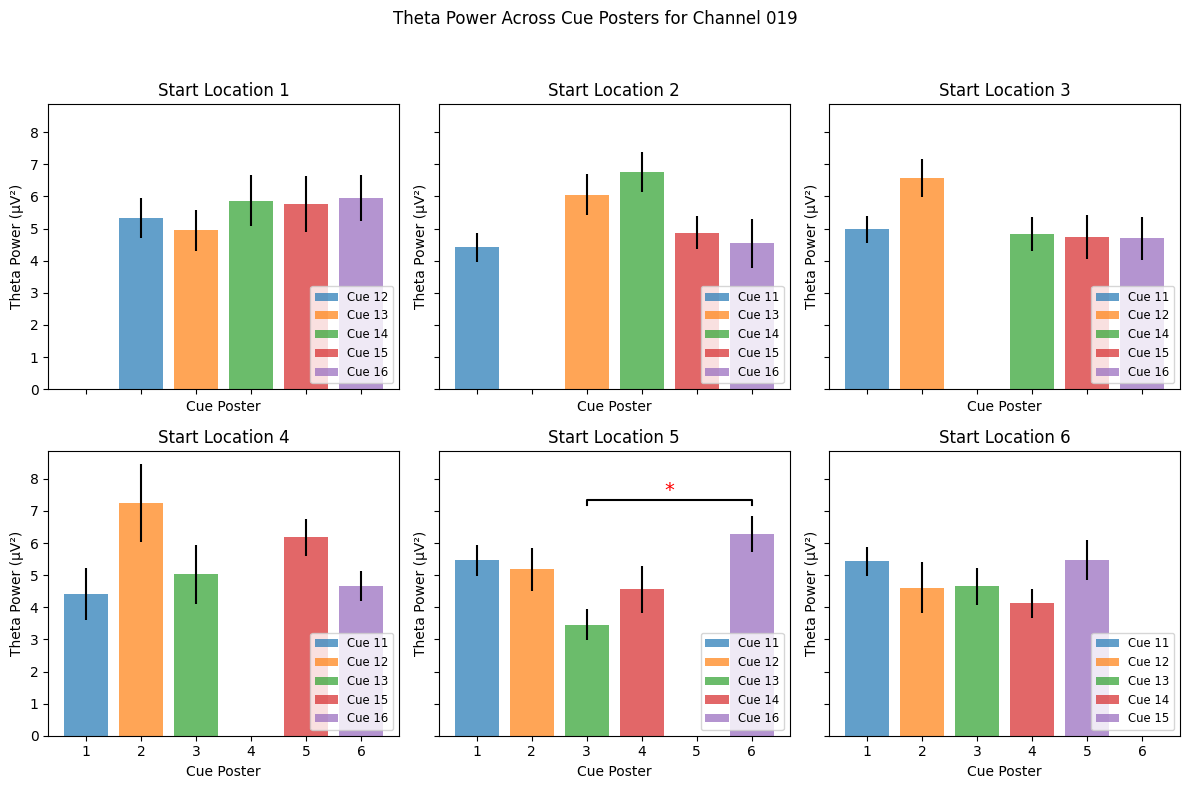

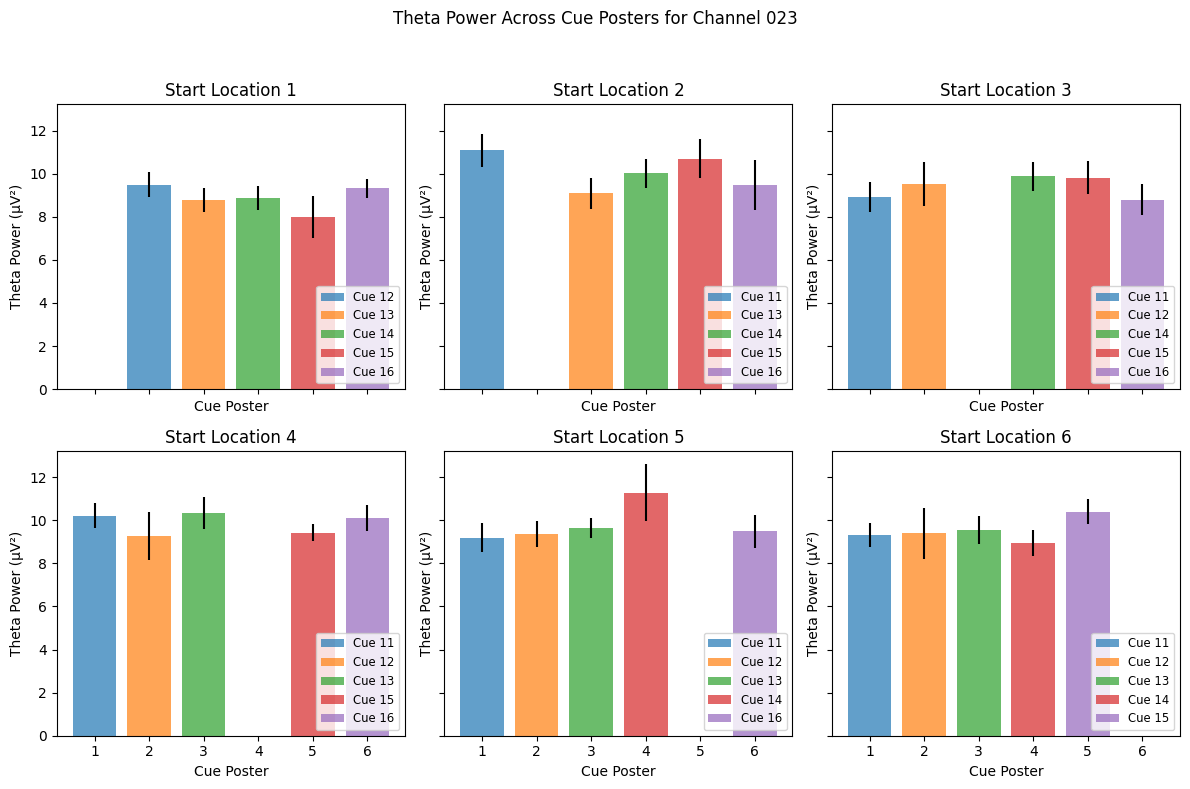

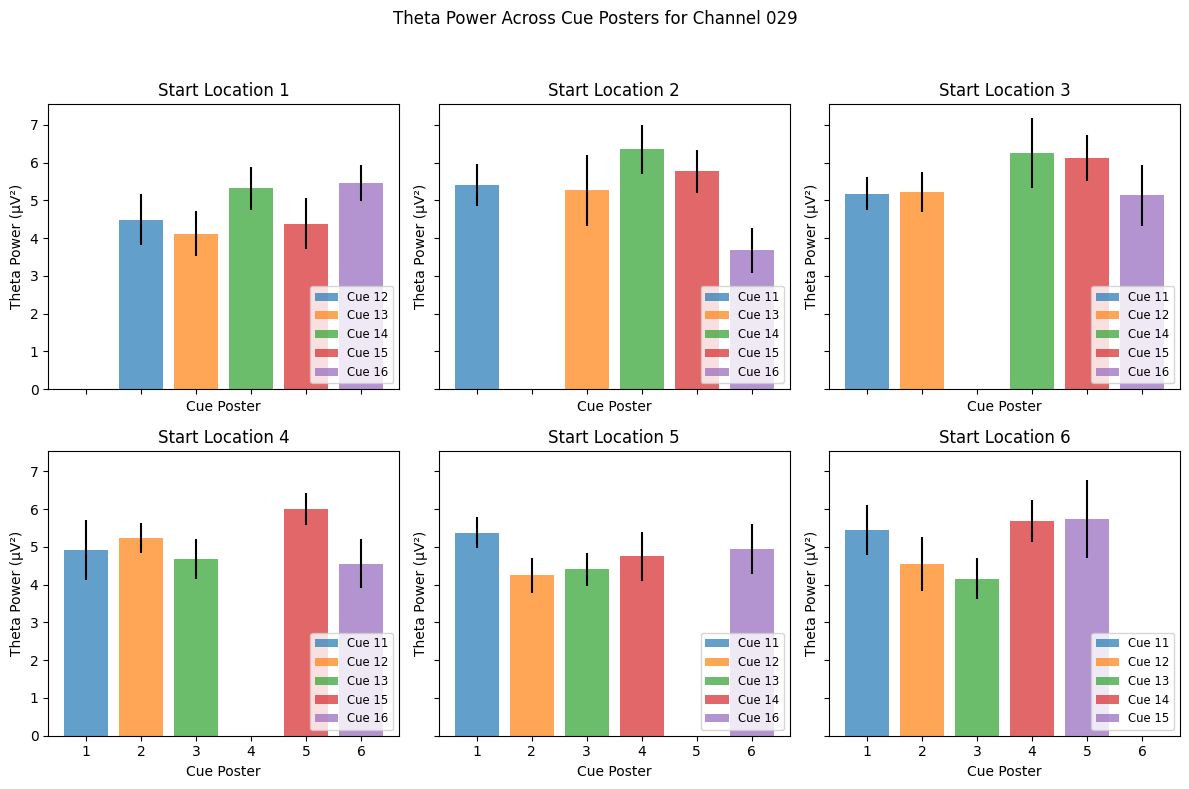

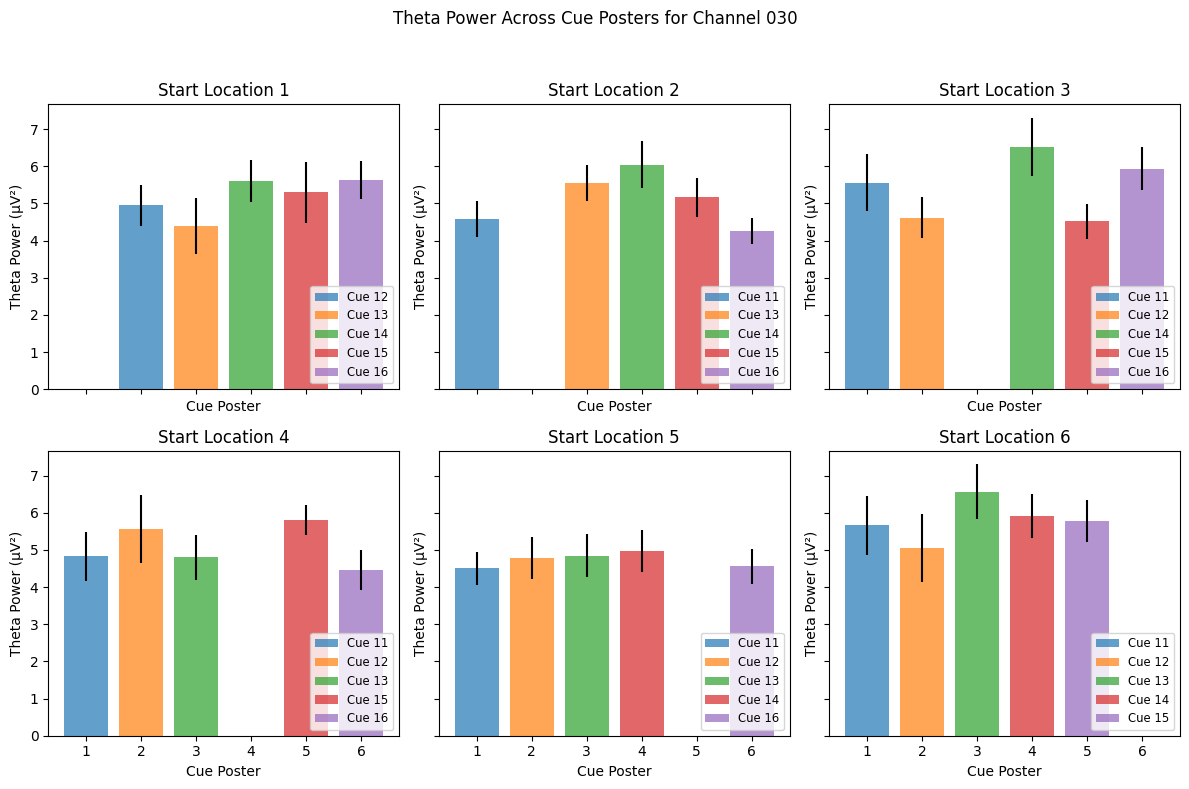

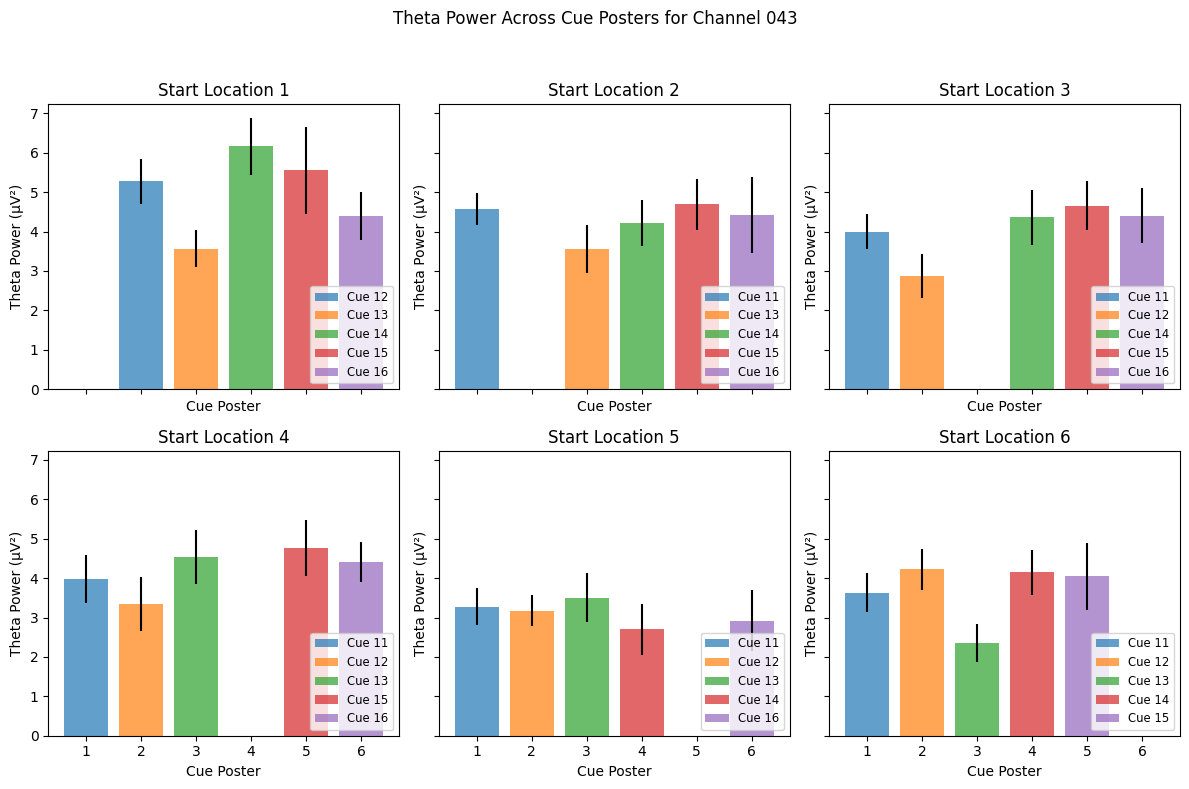

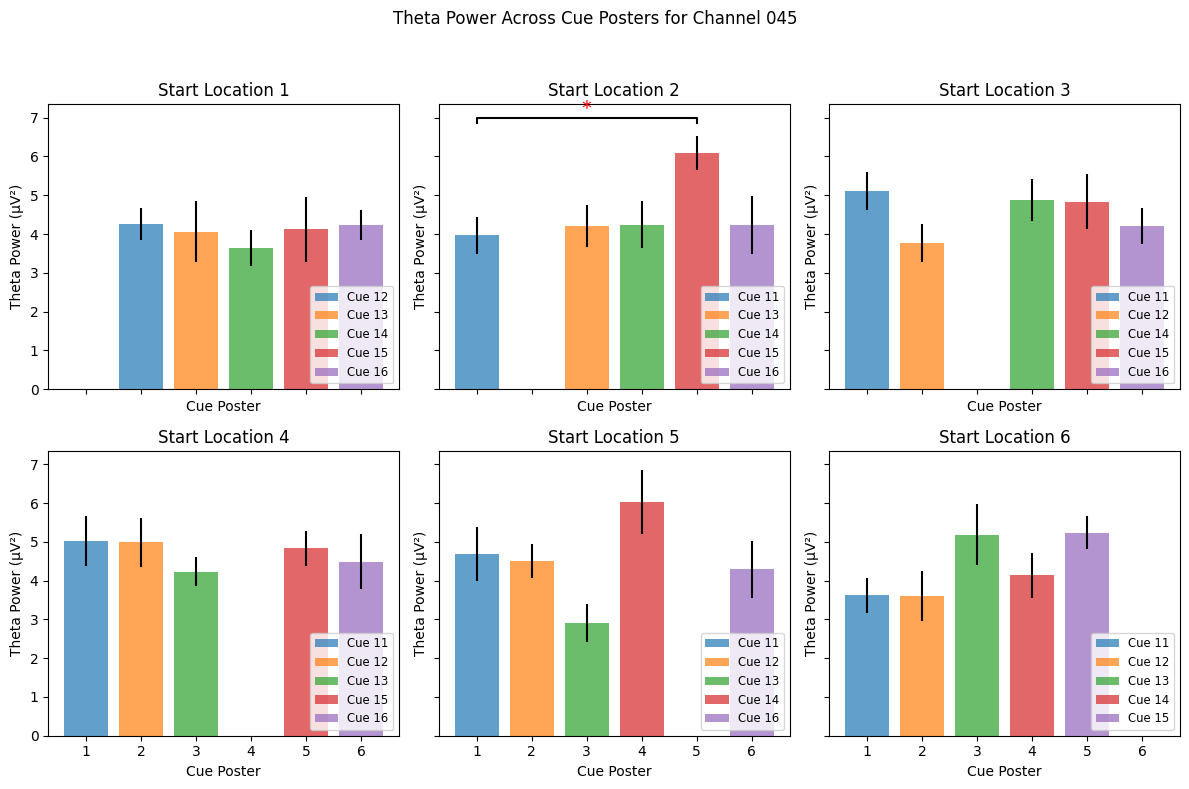

ANOVA results saved to anova_results_theta_power.csv
Bonferroni-corrected Post-hoc results saved to posthoc_results_theta_power.csv

Significant Bonferroni-corrected Post-Hoc Results:
     channel  start_position  group1  group2  mean_diff    t_stat  \
48      019              35      13      16  -2.834673 -3.824898   
312     045              32      11      15  -2.127118 -3.294170   

     p_uncorrected    p_bonf  reject  
48        0.000883  0.008830    True  
312       0.002961  0.029606    True  


In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind, sem
from itertools import combinations

# Initialize result lists
anova_results = []
posthoc_results = []

# Define directory to save figures; create it if it doesn't exist
fig_save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Cue_Period_Analysis/Cue_Start Effects"
if not os.path.exists(fig_save_dir):
    os.makedirs(fig_save_dir)

# Loop over channels
for ch in ch_indx:
    # Convert channel to string if needed (using your mapping)
    ch_str = channel_no[ch]
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    # Loop over start positions
    for i, start_position in enumerate(np.sort(cue_segments_df['start_position'].unique())):
        ax = axes[i]
        theta_power_by_cue = {}  # to store the raw theta power arrays for each cue
        bar_info = {}            # to store the x position, mean and SEM for later annotation
        
        all_theta_powers = []
        all_cue_labels = []

        # Loop over cue onsets (sorted for consistency)
        for j, cue_onset in enumerate(np.sort(cue_segments_df['cue_onset'].unique())):
            # Filter data for current start position, channel, and cue onset
            filtered_df = cue_segments_df.loc[
                (cue_segments_df['start_position'] == start_position) &
                (cue_segments_df['channel'] == ch_str) &
                (cue_segments_df['cue_onset'] == cue_onset)
            ]
            if filtered_df.empty:
                continue

            # Get the PSD and frequency data
            psd_list = filtered_df['flat_spec_og'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # assuming frequency is consistent
            psd_array = np.array(psd_list)

            # Get indices corresponding to the theta band
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]

            # Sum power within theta band and calculate mean and SEM
            mean_psd = np.sum(theta_psd, axis=1)
            mean_theta_power = np.mean(mean_psd)
            sem_theta_power = sem(mean_psd)

            # Store the data for ANOVA and post-hoc comparisons
            theta_power_by_cue[cue_onset] = mean_psd
            all_theta_powers.extend(mean_psd)
            all_cue_labels.extend([cue_onset] * len(mean_psd))

            # Plot the bar and save its x position and y-values for later annotation
            x_pos = j + 1
            bar_info[cue_onset] = (x_pos, mean_theta_power, sem_theta_power)
            ax.bar(x_pos, mean_theta_power, yerr=sem_theta_power, label=f'Cue {cue_onset}', alpha=0.7)

        # Customize subplot
        ax.set_title(f'Start Location {start_position % 10}')
        ax.set_xlabel('Cue Poster')
        ax.set_ylabel('Theta Power (μV²)')
        ax.set_xticks(np.arange(1, len(np.unique(cue_segments_df['cue_onset'])) + 1))
        ax.legend(loc="lower right", fontsize='small')

        # Run ANOVA if more than one cue group is available
        if len(theta_power_by_cue) > 1:
            f_stat, p_value = f_oneway(*theta_power_by_cue.values())
            anova_results.append({
                'channel': ch_str,
                'start_position': start_position,
                'f_stat': f_stat,
                'p_value': p_value
            })

            # Perform pairwise t-tests with Bonferroni correction
            groups = list(theta_power_by_cue.keys())
            n_comparisons = len(groups) * (len(groups) - 1) / 2  # total comparisons

            # Use a dictionary to keep track of vertical offsets for overlapping brackets
            significance_offsets = {}
            
            for group1, group2 in combinations(groups, 2):
                data1 = theta_power_by_cue[group1]
                data2 = theta_power_by_cue[group2]
                t_stat, p_uncorrected = ttest_ind(data1, data2, equal_var=False)
                p_bonf = min(p_uncorrected * n_comparisons, 1.0)
                reject = p_bonf < 0.05
                posthoc_results.append({
                    'channel': ch_str,
                    'start_position': start_position,
                    'group1': group1,
                    'group2': group2,
                    'mean_diff': np.mean(data1) - np.mean(data2),
                    't_stat': t_stat,
                    'p_uncorrected': p_uncorrected,
                    'p_bonf': p_bonf,
                    'reject': reject
                })
                if reject:
                    # Get x positions for the two groups
                    x1 = bar_info[group1][0]
                    x2 = bar_info[group2][0]
                    # Get y positions: bar height plus SEM
                    y1 = bar_info[group1][1] + bar_info[group1][2]
                    y2 = bar_info[group2][1] + bar_info[group2][2]
                    base_y = max(y1, y2)
                    
                    # Determine additional vertical offset to avoid overlapping brackets
                    key = (min(x1, x2), max(x1, x2))
                    offset = significance_offsets.get(key, 0)
                    # Define y position for the bracket; adjust multiplier as needed
                    y = base_y + 0.05 * base_y + offset
                    tick = 0.02 * base_y  # height for the vertical ticks
                    # Draw the bracket: vertical line at x1, horizontal line, vertical line at x2
                    ax.plot([x1, x1, x2, x2],
                            [y, y + tick, y + tick, y],
                            lw=1.5, color='black')
                    # Place an asterisk above the horizontal line in the middle
                    ax.text((x1 + x2) / 2, y + tick, "*", ha='center', va='bottom',
                            fontsize=14, color='red')
                    # Update offset so that subsequent brackets are drawn higher if needed
                    significance_offsets[key] = offset + tick + 0.05 * base_y

    # Add a main title for the entire figure and adjust layout
    plt.suptitle(f'Theta Power Across Cue Posters for Channel {ch_str}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure to the specified directory
    fig_path = os.path.join(fig_save_dir, f"Cue_Start_Effects_Channel_{ch_str}.png")
    plt.savefig(fig_path)
    plt.show()
    plt.close(fig)

# Convert the results to DataFrames and save to CSV files
anova_results_df = pd.DataFrame(anova_results)
posthoc_results_df = pd.DataFrame(posthoc_results)

anova_results_df.to_csv(os.path.join(fig_save_dir, "anova_results_theta_power.csv"), index=False)
posthoc_results_df.to_csv(os.path.join(fig_save_dir, "posthoc_results_theta_power.csv"), index=False)

print("ANOVA results saved to anova_results_theta_power.csv")
print("Bonferroni-corrected Post-hoc results saved to posthoc_results_theta_power.csv")

# Display significant Bonferroni-corrected post-hoc results
significant_posthoc = posthoc_results_df[posthoc_results_df['reject'] == True]
print("\nSignificant Bonferroni-corrected Post-Hoc Results:\n", significant_posthoc)


## Looking at the peak frequencies
### Start by first peak

In [60]:

# 1) Helper function to get first peak frequency
def compute_first_peak_freq(df, key='peak_freqs'):
    first_peaks = []
    for peak_list in df[key]:
        if isinstance(peak_list, (list, tuple, np.ndarray)) and len(peak_list) > 0:
            first_peaks.append(peak_list[0])
    return first_peaks

# 2) Directory to save figures
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/Control_Compare/Peak_Freqs_Fig"
os.makedirs(save_dir, exist_ok=True)

# 3) Prepare a list to hold statistical test results
combined_results = []

# 4) Main loop over channels
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # =======================================================================
    # A) Bar Charts for First Peak Frequency
    # =======================================================================
    fig_bar, axes_bar = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    axes_bar = axes_bar.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes_bar[i]
        
        # Filter data
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        # Gather first peak frequencies for each group
        group_data = {}
        
        # Cue: separate by each unique cue_onset
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                first_peaks = compute_first_peak_freq(onset_data, key='peak_freqs')
                if len(first_peaks) > 0:
                    group_data[f'Cue {onset}'] = first_peaks
        
        # Control: combine all control trials
        control_peaks = compute_first_peak_freq(control_data, key='peak_freqs')
        if len(control_peaks) > 0:
            group_data['Control'] = control_peaks
        
        labels = list(group_data.keys())
        if len(labels) > 1:
            # One-way ANOVA
            anova_data = [group_data[label] for label in labels]
            f_stat, p_val = f_oneway(*anova_data)
            
            # Bonferroni correction
            n_comparisons = len(labels) - 1
            adjusted_p_value = min(p_val * n_comparisons, 1.0)
            
            combined_results.append({
                'channel': channel_str,
                'start_position': start_position,
                'test_type': 'ANOVA (BarChart, First Peak)',
                'f_stat': f_stat,
                'p_value': p_val,
                'p_adj': adjusted_p_value,
                'reject': adjusted_p_value < 0.05
            })
            
            ax.text(0.05, 0.9, f'ANOVA p_adj={adjusted_p_value:.3f}',
                    transform=ax.transAxes, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.6))
        
        # Bar chart
        if labels:
            means = [np.mean(group_data[label]) for label in labels]
            sems = [sem(group_data[label]) for label in labels]
            x = np.arange(len(labels))
            ax.bar(x, means, yerr=sems, width=0.5, alpha=0.7, capsize=5, color='skyblue')
            ax.set_xticks(x)
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        
        ax.set_title(f'Channel {channel_str} | Start Pos {start_position}', fontsize=10)
        ax.set_xlabel('Condition', fontsize=9)
        ax.set_ylabel('First Peak Freq (Hz)', fontsize=9)
    
    fig_bar.suptitle(f'First Peak Frequency - Bar Charts - Channel {channel_str}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    # Save the bar chart figure
    bar_fig_path = os.path.join(save_dir, f"Bar_FirstPeak_Channel_{channel_str}.png")
    fig_bar.savefig(bar_fig_path, dpi=300)
    plt.close(fig_bar)
    
    # =======================================================================
    # B) Heatmaps (Pairwise Tukey for First Peak Frequency)
    # =======================================================================
    fig_heat, axes_heat = plt.subplots(2, 3, figsize=(15, 10))
    axes_heat = axes_heat.flatten()
    im_for_colorbar = None
    
    for i, start_position in enumerate(start_positions):
        ax_heat = axes_heat[i]
        
        # Re-create group_data for the same channel & start position
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        group_data = {}
        
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                first_peaks = compute_first_peak_freq(onset_data, key='peak_freqs')
                if len(first_peaks) > 0:
                    group_data[f'Cue {onset}'] = first_peaks
        
        control_peaks = compute_first_peak_freq(control_data, key='peak_freqs')
        if len(control_peaks) > 0:
            group_data['Control'] = control_peaks
        
        if len(group_data.keys()) > 1:
            # Build a long DataFrame for Tukey
            data_long = []
            for grp, freq_list in group_data.items():
                for val in freq_list:
                    data_long.append({'peak_freq': val, 'group': grp})
            df_long = pd.DataFrame(data_long)
            
            # Tukey HSD
            tukey_results = pg.pairwise_tukey(dv='peak_freq', between='group', data=df_long)
            
            # Build p-value matrix
            unique_groups = sorted(df_long['group'].unique())
            p_matrix = pd.DataFrame(np.ones((len(unique_groups), len(unique_groups))),
                                    index=unique_groups, columns=unique_groups)
            for _, row in tukey_results.iterrows():
                grp1 = row['A']
                grp2 = row['B']
                # Use whichever p-value column is present
                if 'p-corr' in tukey_results.columns:
                    p_val_corr = row['p-corr']
                elif 'p-tukey' in tukey_results.columns:
                    p_val_corr = row['p-tukey']
                else:
                    p_val_corr = row['p-unc']
                
                p_matrix.loc[grp1, grp2] = p_val_corr
                p_matrix.loc[grp2, grp1] = p_val_corr
            
            im = ax_heat.matshow(p_matrix, cmap='viridis', vmin=0, vmax=1)
            if im_for_colorbar is None:
                im_for_colorbar = im
            
            ax_heat.set_xticks(np.arange(len(unique_groups)))
            ax_heat.set_yticks(np.arange(len(unique_groups)))
            ax_heat.set_xticklabels(unique_groups, rotation=45, ha='left', fontsize=8)
            ax_heat.set_yticklabels(unique_groups, fontsize=8)
            ax_heat.set_title(f'Start Pos {start_position}', fontsize=10)
            
            # Annotate each cell with p-value
            for (m, n), val in np.ndenumerate(p_matrix.values):
                text_color = 'white' if val < 0.5 else 'black'
                ax_heat.text(n, m, f'{val:.3f}', ha='center', va='center', color=text_color, fontsize=8)
        else:
            ax_heat.text(0.5, 0.5, "Not enough\ndata", ha='center', va='center', fontsize=12)
            ax_heat.axis('off')
    
    fig_heat.suptitle(f'Tukey HSD p-values (First Peak) - Channel {channel_str}', fontsize=14)
    if im_for_colorbar is not None:
        fig_heat.colorbar(im_for_colorbar, ax=axes_heat.ravel().tolist(),
                          shrink=0.6, label='Corrected p-value')
    
    # Save the heatmap figure
    heatmap_fig_path = os.path.join(save_dir, f"Heatmap_FirstPeak_Channel_{channel_str}.png")
    fig_heat.savefig(heatmap_fig_path, dpi=300)
    plt.close(fig_heat)
    
    # =======================================================================
    # C) Violin Plots (with Significance Markers for First Peak Frequency)
    # =======================================================================
    fig_violin, axes_violin = plt.subplots(2, 3, figsize=(20, 15), sharey=True)
    axes_violin = axes_violin.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes_violin[i]
        
        # Filter data
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        group_data = {}
        
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                onset_data = cue_data[cue_data['cue_onset'] == onset]
                first_peaks = compute_first_peak_freq(onset_data, key='peak_freqs')
                if len(first_peaks) > 0:
                    group_data[f'Cue {onset}'] = first_peaks
        
        control_peaks = compute_first_peak_freq(control_data, key='peak_freqs')
        if len(control_peaks) > 0:
            group_data['Control'] = control_peaks
        
        labels = list(group_data.keys())
        if len(labels) > 1:
            # One-way ANOVA
            anova_data = [group_data[label] for label in labels]
            f_stat, p_val = f_oneway(*anova_data)
            
            # Bonferroni correction
            n_comparisons = len(labels) - 1
            adjusted_p_value = min(p_val * n_comparisons, 1.0)
            
            combined_results.append({
                'channel': channel_str,
                'start_position': start_position,
                'test_type': 'ANOVA (Violin, First Peak)',
                'f_stat': f_stat,
                'p_value': p_val,
                'p_adj': adjusted_p_value,
                'reject': adjusted_p_value < 0.05
            })
            
            ax.text(0.05, 0.9, f'ANOVA p_adj={adjusted_p_value:.3f}',
                    transform=ax.transAxes, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.6))
        
        # Violin plot
        if labels:
            # Sort any 'Cue X' labels numerically
            cue_labels = [k for k in labels if k.startswith('Cue')]
            cue_labels_sorted = sorted(cue_labels, key=lambda x: float(x.split()[1]))
            final_labels = cue_labels_sorted + ([k for k in labels if k == 'Control'] if 'Control' in labels else [])
            
            data_list = [group_data[label] for label in final_labels]
            positions = np.arange(len(final_labels))
            
            vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7, showextrema=False)
            ax.set_xticks(positions)
            ax.set_xticklabels(final_labels, rotation=45, ha='right', fontsize=9)
            
            # Overlay individual data points
            for pos, label in zip(positions, final_labels):
                y_data = group_data[label]
                x_jitter = pos + 0.05 * np.random.randn(len(y_data))
                ax.scatter(x_jitter, y_data, color='black', s=10, alpha=0.5)
            
            # Post Hoc & Significance
            data_long = []
            for grp in final_labels:
                for val in group_data[grp]:
                    data_long.append({'peak_freq': val, 'group': grp})
            df_long = pd.DataFrame(data_long)
            
            tukey_results = pg.pairwise_tukey(dv='peak_freq', between='group', data=df_long)
            
            # Helper to get the correct p-value
            def get_p_val(row):
                if 'p-corr' in row:
                    return row['p-corr']
                elif 'p-tukey' in row:
                    return row['p-tukey']
                else:
                    return row['p-unc']
            
            all_vals = np.concatenate(data_list)
            global_max = np.max(all_vals)
            global_min = np.min(all_vals)
            y_range = global_max - global_min
            offset_val = y_range * 0.1
            
            significance_offsets = {}
            for _, row in tukey_results.iterrows():
                p_val_signif = get_p_val(row)
                if p_val_signif < 0.05:
                    grp1 = row['A']
                    grp2 = row['B']
                    if grp1 in final_labels and grp2 in final_labels:
                        i1 = final_labels.index(grp1)
                        i2 = final_labels.index(grp2)
                        base_level = max(np.max(group_data[grp1]), np.max(group_data[grp2]))
                        key = (min(i1, i2), max(i1, i2))
                        extra_offset = significance_offsets.get(key, 0)
                        y_level = base_level + offset_val + extra_offset
                        significance_offsets[key] = extra_offset + offset_val * 0.5
                        
                        # Draw significance bar
                        x1, x2 = i1, i2
                        ax.plot([x1, x1, x2, x2],
                                [y_level - offset_val * 0.2, y_level, y_level, y_level - offset_val * 0.2],
                                lw=1.5, c='black')
                        ax.text((x1 + x2) / 2, y_level, "*", ha='center', va='bottom',
                                color='black', fontsize=12)
        
        ax.set_title(f'Channel {channel_str} | Start Pos {start_position}', fontsize=10)
        ax.set_xlabel('Condition', fontsize=9)
        ax.set_ylabel('First Peak Freq (Hz)', fontsize=9)
    
    fig_violin.suptitle(f'Violin Plot of First Peak Frequency - Channel {channel_str}', fontsize=14)
    plt.tight_layout()
    
    # Save the violin figure
    violin_fig_path = os.path.join(save_dir, f"Violin_FirstPeak_Channel_{channel_str}.png")
    fig_violin.savefig(violin_fig_path, dpi=300)
    plt.close(fig_violin)

# -------------------------------------------------------------------------
# 5) Save combined ANOVA results to CSV
results_df = pd.DataFrame(combined_results)
csv_path = os.path.join(save_dir, "combined_anova_bonferroni_first_peak.csv")
results_df.to_csv(csv_path, index=False)
print(f"Combined ANOVA results (with Bonferroni correction) saved to {csv_path}")

# 6) Optionally, display significant comparisons
significant_results = results_df[results_df['reject'] == True]
print("\nSignificant Comparisons (First Peak Frequency):\n", significant_results)


Combined ANOVA results (with Bonferroni correction) saved to /Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105/test/combined_anova_bonferroni_first_peak.csv

Significant Comparisons (First Peak Frequency):
    channel  start_position                     test_type    f_stat   p_value  \
12     023              31  ANOVA (BarChart, First Peak)  5.962337  0.000058   
14     023              33  ANOVA (BarChart, First Peak)  6.418541  0.000030   
15     023              34  ANOVA (BarChart, First Peak)  3.616048  0.004624   
16     023              35  ANOVA (BarChart, First Peak)  4.649055  0.000719   
17     023              36  ANOVA (BarChart, First Peak)  6.402088  0.000029   
18     023              31    ANOVA (Violin, First Peak)  5.962337  0.000058   
20     023              33    ANOVA (Violin, First Peak)  6.418541  0.000030   
21     023              34    ANOVA (Violin, First Peak)  3.616048  0.004624   
22     023              35    ANOVA (Violin, Fi

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Helper function to compute detection probability for a given peak order ---
def compute_peak_detection(df, peak_idx=1, key='peak_freqs'):
    """
    Returns the proportion of trials (rows) in the DataFrame df 
    where the length of the list in column 'peak_freqs' is at least peak_idx.
    """
    if df.empty:
        return np.nan
    # Create a binary indicator: 1 if at least peak_idx peaks exist, else 0
    indicator = df[key].apply(lambda x: 1 if isinstance(x, (list, tuple, np.ndarray)) and len(x) >= peak_idx else 0)
    return indicator.mean()

# --- Directory for saving figures ---
save_dir = "/Users/liuyuanwei/Documents/GitHub/FYP-Pyhipp/LFP_Analysis/Figures/20181105"
os.makedirs(save_dir, exist_ok=True)

# --- Loop over channels ---
for ch in ch_indx:
    channel_str = channel_no[ch]
    
    # --- Create a figure for detection probabilities (grouped bar plots) ---
    # We'll create one subplot per start position (assumed to be 6 in a 2x3 grid)
    fig_prob, axes_prob = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    axes_prob = axes_prob.flatten()
    
    for i, start_position in enumerate(start_positions):
        ax = axes_prob[i]
        
        # Filter data for the current channel and start position
        cue_data = cue_segments_df[
            (cue_segments_df['channel'] == channel_str) &
            (cue_segments_df['start_position'] == start_position)
        ]
        control_data = control_segments_df[
            (control_segments_df['channel'] == channel_str) &
            (control_segments_df['start_position'] == start_position)
        ]
        
        # Build a dictionary that holds, for each condition, the detection probabilities for peak 1, 2, and 3
        detection_probs = {}
        
        # For cue conditions: separate by each unique cue onset
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                sub_df = cue_data[cue_data['cue_onset'] == onset]
                p1 = compute_peak_detection(sub_df, peak_idx=1, key='peak_freqs')
                p2 = compute_peak_detection(sub_df, peak_idx=2, key='peak_freqs')
                p3 = compute_peak_detection(sub_df, peak_idx=3, key='peak_freqs')
                detection_probs[f'Cue {onset}'] = [p1, p2, p3]
        
        # For control condition
        if not control_data.empty:
            p1 = compute_peak_detection(control_data, peak_idx=1, key='peak_freqs')
            p2 = compute_peak_detection(control_data, peak_idx=2, key='peak_freqs')
            p3 = compute_peak_detection(control_data, peak_idx=3, key='peak_freqs')
            detection_probs['Control'] = [p1, p2, p3]
        
        # If no conditions are present, skip plotting for this start position
        if not detection_probs:
            ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue
        
        # Create a grouped bar plot:
        conditions = list(detection_probs.keys())
        n_conditions = len(conditions)
        x = np.arange(n_conditions)  # one tick per condition
        peak_orders = [1, 2, 3]
        n_peaks = len(peak_orders)
        bar_width = 0.2
        
        # For each peak order, plot a set of bars with an offset
        offsets = np.linspace(-bar_width, bar_width, n_peaks)
        for idx, peak in enumerate(peak_orders):
            # Get the detection probability for each condition for the given peak
            vals = [detection_probs[cond][idx] for cond in conditions]
            ax.bar(x + offsets[idx], vals, width=bar_width, label=f'Peak {peak}')
        
        ax.set_xticks(x)
        ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=9)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Detection Probability')
        ax.set_title(f'Start Pos {start_position}', fontsize=10)
        ax.legend(fontsize=8)
    
    fig_prob.suptitle(f'Peak Detection Probabilities - Channel {channel_str}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    # Save the probability figure
    prob_fig_path = os.path.join(save_dir, f"PeakDetectionProb_Channel_{channel_str}.png")
    fig_prob.savefig(prob_fig_path, dpi=300)
    plt.close(fig_prob)
